To do:
1. Clean graphs

Hypotheses:
1. AI usage ~ industry (game software vs webtoon/comix)
2. AI copyright perception ~ different jobs (student, employee, researcher)
3. AI copyright conflict perception ~ AI usage
4. AI reliability perception ~ AI usage
5. AI policy improvement perception ~ industry background

In [1]:
# import packages

import pandas as pd
import pyreadstat
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
import textwrap

In [2]:
# import dataset

df, meta = pyreadstat.read_sav("survey_data.sav")

In [ ]:
# eliminate unnecessary columns containing personal info such as e-mail (already preprocessed as will upload sav file to public repository, these columns have NaN values)

df = df.iloc[:, 5:]

In [6]:
# translate survey questions (columns) from Korean into English, reformat for readability

translated_cols_list = ['1. Occupation', '2. Age', '3. Level of Experience', '4. Type of AI used', '5. AI usage rate', '6. AI stage used', '7. AI quality effect', '8. AI creativity effect', '9. AI working time effect', '10. AI technical limits','11. AI copyright needed', '12. AI copyright holder', '13. AI human intervention needed', '14. AI human intervention needed field', '15. AI human intervention copyright needed', '16. AI human intervention distinguish difficulty', '17. AI legal issues', '18. AI copyright law adequate', '19. AI copyright policy adequate', '20. AI copyright improvement', '21. AI copyright conflict', '22. AI copyright conflict legal role', '23. AI piracy experience', '24. AI piracy effect', '25. AI piracy advantage']

translate_cols_dict = {list(df.columns)[i]: translated_cols_list[i] for i in range(len(df.columns))}

df.rename(columns = translate_cols_dict, inplace = True)

In [162]:
# create dictionaries for data cleaning

col1_values_dict = {'웹툰/코믹스 관련 학과 대학생': 'Undergraduate majoring in webtoon/comix',
                    '게임 관련 학과 대학생': 'Undergraduate majoring in games',
                    '웹툰/코믹스 제작 회사 종사자': 'Employee at a webtoon/comix company',
                    '게임 제작 회사 종사자': 'Employee at a game company',
                    '게임 관련 연구원': 'Researcher in games',
                    '웹툰/코믹스 관련 연구원': 'Researcher in webtoon/comix',
                    'Sinh viên đại học khoa liên quan đến webtoon/comix': 'Undergraduate majoring in webtoon/comix',
                    'Sinh viên đại học khoa liên quan đến trò chơi điện tử': 'Undergraduate majoring in games',
                    'Nhân viên làm việc tại công ty sản xuất webtoon/comix': 'Employee at a webtoon/comix company',
                    'Những người làm việc trong công ty sản xuất game': 'Employee at a game company',
                    'Nhà nghiên cứu liên quan đến trò chơi điện tử': 'Researcher in games',
                    'Nhà nghiên cứu liên quan đến webtoon/comix': 'Researcher in webtoon/comix'
                    }

col2_values_dict = {'20대': '20s and below',
                    '30대': '30s',
                    '40대': '40s',
                    '50대 이상': '50s and above',
                    'Dưới 20 tuổi': '20s and below',
                    'Độ tuổi 30': '30s',
                    'Độ tuổi 40': '40s',
                    'Trên 50 tuổi': '50s and above'
                    }

col3_values_dict = {'1년 미만': 'Less than a year',
                    '1~3년': '1 ~ 3 years',
                    '4~7년': '4 ~ 7 years',
                    '8년 이상': '8 years and above',
                    'chưa đầy một năm': 'Less than a year',
                    '1~3 năm': '1 ~ 3 years',
                    '4~7 năm': '4 ~ 7 years',
                    'hơn 8 năm': '8 years and above'
                    }

col4_values_dict = {'머신러닝': 'Machine Learning',
                    '딥러닝': 'Deep Learning',
                    '자연어 처리': 'Natural Language Processing',
                    '컴퓨터 비전': 'Computer Vision',
                    'Học máy':'Machine Learning',
                    'Học sâu': 'Deep Learning',
                    'Xử lý ngôn ngữ tự nhiên': 'Natural Language Processing',
                    'Tầm nhìn máy tính': 'Computer Vision'
                    }

col5_values_dict = {r'^매우 높음$': 'Very high',
                    r'^높음$': 'High',
                    r'^보통$': 'Medium',
                    r'^낮음$': 'Low',
                    r'^매우 낮음$': 'Very low',
                    r'^Rất cao$': 'Very high',
                    r'^Cao$': 'High',
                    r'^Trung bình$': 'Medium',
                    r'^Thấp$': 'Low',
                    r'^Rất thấp$': 'Very low'
                    }

col6_values_dict = {'아이디어 생성 단계': 'Brainstorming',
                    '캐릭터 디자인 및 생성': 'Character design and creation',
                    '스토리라인 자동화': 'Story generation',
                    '배경 및 디테일 작업': 'Background and details',
                    'QA 및 디버깅': 'QA and debugging',
                    'Giai đoạn nảy sinh ý tưởng':'Brainstorming',
                    'Thiết kế và tạo hình nhân vật': 'Character design and creation',
                    'Tự động hóa cốt truyện': 'Story generation',
                    'Bối cảnh và chi tiết': 'Background and details',
                    'QA và gỡ lỗi': 'QA and debugging'
                    }

col7_values_dict = {r'^매우 긍정적$': 'Very positive',
                    r'^긍적적$': 'Positive',
                    r'^보통$': 'Neutral',
                    r'^부정적$': 'Negative',
                    r'^매우 부정적$': 'Very negative',
                    r'^Rất tích cực$': 'Very positive',
                    r'^Tích cực$':'Positive',
                    r'^Bình thường$': 'Neutral',
                    r'^Tiêu cực$': 'Negative',
                    r'^Rất tiêu cực$': 'Very negative'
                    }

col8_values_dict = {'매우 많이 향상됨': 'Greatly improved',
                    '다소 향상됨': 'Somewhat improved',
                    '보통': 'Neutral',
                    '향상되지 않음': 'No improvement',
                    '오히려 제한하고 있음': 'On the contrary, more limited',
                    'Cải thiện rất nhiều': 'Greatly improved',
                    'Cải thiện ít nhiều': 'Somewhat improved',
                    'Bình thường': 'Neutral',
                    'Không cải thiện': 'No improvement',
                    'Trái lại còn bị hạn chế nữa': 'On the contrary, more limited'
                    }

col9_values_dict = {'매우 많이 단축됨': 'Shortened greatly',
                    '어느 정도 단축됨': 'Shortened to an extent',
                    '거의 차이가 없음': 'Almost no difference',
                    '작업 시간이 오히려 늘어남': 'On the contrary, increased',
                    'Rút ngắn rất nhiều':'Shortened greatly',
                    'Được rút ngắn ở một mức độ nào đó': 'Shortened to an extent',
                    'Gần như không có gì khác biệt': 'Almost no difference',
                    'Ngược lại thời gian làm việc lại tăng lên': 'On the contrary, increased'
                    }

col10_values_dict = {'데이터 부족': 'Lack of data',
                    '낮은 AI 모델의 정확성': 'Low accuracy of AI models',
                    '법적/윤리적 문제': 'Legal/ethical issues',
                    '도구의 비용 및 접근성': 'Cost and accessibility of AI',
                    'Thiếu dữ liệu': 'Lack of data',
                    'Độ chính xác của mô hình AI thấp': 'Low accuracy of AI models',
                    'Vấn đề pháp lý / đạo đức': 'Legal/ethical issues',
                    'Chi phí và khả năng tiếp cận của công cụ': 'Cost and accessibility of AI'
                    }


col11_values_dict = {r'^매우 그렇다$': 'Very necessary',
                    r'^그렇다$': 'Necessary',
                    r'^보통이다$': 'Moderate',
                    r'^그렇지 않다$': 'Unnecessary',
                    r'^전혀 그렇지 않다$': 'Very unnecessary',
                    r'^Rất cần thiết$': 'Very necessary',
                    r'^Cần thiết$': 'Necessary',
                    r'^Bình thường$': 'Moderate',
                    r'^Không cần thiết$': 'Unnecessary',
                    r'^Rất không cần thiết$': 'Very unnecessary'
                    }

# check 4. Vietnamese
col12_values_dict = {'AI 개발자': 'AI developer',
                    'AI 플랫폼': 'AI platform',
                    r'AI 사용자 \(작가 또는 디자이너\)': 'AI user (writer or designer)',
                    'AI 자체': 'AI itself',
                    r'공동 소유 \(AI 개발자와와 사용자\)': 'Co-owned (AI developer and user)',
                    'Nhà phát triển AI': 'AI developer',
                    'Nền tảng AI': 'AI platform',
                    r'Người dùng AI \(nhà văn hoặc nhà thiết kế\)': 'AI user (writer or designer)',
                    'AI đó.': 'AI itself',
                    r'Đồng sở hữu \(nhà phát triển và người dùng AI\)': 'Co-owned (AI developer and user)'
                    }

col13_values_dict = col11_values_dict

col14_values_dict = {'캐릭터 디자인': 'Character design',
                    '스토리 전개': 'Story development',
                    '레벨디자인': 'Level design',
                    r'\(게임\) 사용자 행동 예측': '(Game) Predicting user behavior',
                    r'\(게임\) 실시간 게임 콘텐츠 생성': '(Game) Creating live game content',
                    r'\(웹툰/코믹스\) 자동채색': '(Webtoons / Comics) Auto-coloring',
                    r'\(웹툰/코믹스\) 배경생성': '(Webtoons / Comics) Background generation',
                    r'\(웹툰/코믹스\) 대화체 작성': '(Webtoons / Comics) Creating dialogue',
                    'Thiết kế nhân vật': 'Character design',
                    'Triển khai câu chuyện': 'Story development',
                    'Thiết kế cấp bậc': 'Level design',
                    r'\(Game\) Dự đoán hành vi của người dùng': '(Game) Predicting user behavior',
                    r'\(Game\) Tạo nội dung trò chơi trực tiếp': '(Game) Creating live game content',
                    r'\(Webtoons / Comics\) Tự động tô màu': '(Webtoons / Comics) Auto-coloring',
                    r'\(Webtoons / Comics\) Tạo bối cảnh': '(Webtoons / Comics) Background generation',
                    r'\(Webtoons / Comics\) Viết đối thoại': '(Webtoons / Comics) Creating dialogue'
                    }

col15_values_dict = col11_values_dict

col16_values_dict = {r'^매우 그렇다$': 'Very easy',
                    r'^그렇다$': 'Easy',
                    r'^보통이다$': 'Moderate',
                    r'^그렇지 않다$': 'Difficult',
                    r'^전혀 그렇지 않다$': 'Very difficult',
                    r'^Rất cần thiết$': 'Very easy',
                    r'^Cần thiết$': 'Easy',
                    r'^Bình thường$': 'Moderate',
                    r'^Không cần thiết$': 'Difficult',
                    r'^Rất không cần thiết$': 'Very difficult'
                    }

col17_values_dict = {r'저작권자 확정\(귀속\) 문제': 'Determining copyright status',
                    '원본 콘텐츠와 AI 생성물의 구분 문제': 'Distinguishing between original and AI-generated content',
                    '저작권 침해 가능성': 'Possibility of copyright infringement',
                    'AI 모델의 학습 데이터 사용 문제': 'Problems with data used by AI models',
                    r'Vấn đề xác định người sở hữu bản quyền \( thuộc\)': 'Determining copyright status',
                    'Vấn đề phân biệt giữa nội dung gốc và sản phẩm tạo ra AI': 'Distinguishing between original and AI-generated content',
                    'Khả năng vi phạm bản quyền': 'Possibility of copyright infringement',
                    'Vấn đề sử dụng dữ liệu học tập của mô hình AI': 'Problems with data used by AI models',
                    }

col18_values_dict = {r'^매우 그렇다$': 'Very protective',
                    r'^그렇다$': 'Protective',
                    r'^보통이다$': 'Moderate',
                    r'^그렇지 않다$': 'Little protection',
                    r'^전혀 그렇지 않다$': 'No protection at all',
                    r'^Rất bảo vệ$': 'Very protective',
                    r'^Bảo vệ$': 'Protective',
                    r'^Bình thường$': 'Moderate',
                    r'^Ít Bảo vệ$': 'Little protection',
                    r'^Hoàn toàn không bảo vệ$': 'No protection at all'
                    }

col19_values_dict = {r'^매우 그렇다$': 'Very adequate',
                    r'^그렇다$': 'Adequate',
                    r'^보통이다$': 'Moderate',
                    r'^그렇지 않다$': 'Inadequate',
                    r'^전혀 그렇지 않다$': 'None at all',
                    r'^Rất đủ nỗ lực$': 'Very adequate',
                    r'^Đủ nỗ lực$' : 'Adequate',
                    r'^bình thường$': 'Moderate',
                    r'^Ít nỗ lực$': 'Inadequate',
                    r'^Hoàn toàn không nỗ lực$': 'None at all'
                    }

col20_values_dict = {r'AI 저작물의 저작권자 명확화\(새로운 해석론을 통해\)': 'Clarifying copyright status in AI works (through a new theoretical basis)',
                    'AI 생성 콘텐츠에 대한 새로운 법률 신설': 'New laws on AI-generated content',
                    '기존 저작권법 개정': 'Amending existing copyright laws',
                    '국제 협력 및 기준 마련': 'International cooperation and standardization',
                    r'Làm rõ người có bản quyền tác phẩm AI \(thông qua lý thuyết phân tích mới\)': 'Clarifying copyright status in AI works (through a new theoretical basis)',
                    'Luật mới về nội dung tạo ra AI': 'New laws on AI-generated content',
                    'Sửa đổi luật bản quyền vốn có': 'Amending existing copyright laws',
                    'Hợp tác quốc tế và chuẩn bị tiêu chuẩn': 'International cooperation and standardization'
                    }

# Check 1. Vietnamese
col21_values_dict = {r'AI 생성 콘텐츠의 저작권자 확정\(귀속\) 문제': 'Issues with determining the copyright holder of AI-generated content',
                    'AI의 창작 능력에 대한 법적 인정 부족': 'Lack of legal recognition regarding the creativity of AI',
                    'AI 생성 콘텐츠의 독창성 문제': 'Problems with creativity in AI-generated content',
                    'AI 훈련 데이터의 저작권 문제': 'Copyright issues with AI training data',
                    r'Vấn đề xác định người sở hữu bản quyền \(thuê\) nội dung tạo ra AI.': 'Issues with determining the copyright holder of AI-generated content',
                    'Thiếu sự công nhận hợp pháp về năng lực sáng tạo của AI': 'Lack of legal recognition regarding the creativity of AI',
                    'Vấn đề về tính sáng tạo của nội dung tạo AI': 'Problems with creativity in AI-generated content',
                    'Vấn đề bản quyền của dữ liệu huấn luyện AI': 'Copyright issues with AI training data'
                    }

col22_values_dict = {'분쟁 해결을 위한 명확한 법적 기준 제시': 'Providing clear legal standards to resolve disputes',
                    '새로운 법률 및 규정 도입': 'Creating new laws and regulations',
                    '기존 법률의 해석 및 적용': 'Interpreting and applying existing laws',
                    '국제적인 협력을 통한 분쟁 해결': 'Resolving disputes through international cooperation',
                    'Đưa ra các tiêu chuẩn pháp lý rõ ràng để giải quyết tranh chấp': 'Providing clear legal standards to resolve disputes',
                    'Áp dụng luật và quy định mới': 'Creating new laws and regulations',
                    'Giải thích và áp dụng luật hiện hành': 'Interpreting and applying existing laws',
                    'Giải quyết tranh chấp thông qua hợp tác quốc tế': 'Resolving disputes through international cooperation'
                    }

col23_values_dict = {'예': 'Yes',
                     '아니요': 'No',
                     'Có': 'Yes',
                     'Chưa có': 'No'
                     }

col24_values_dict = {r'^매우 효과적이다$': 'Very effective',
                    r'^어느 정도 효과적이다$': 'Somewhat effective',
                    r'^보통이다$': 'Moderate',
                    r'^효과적이지 않다$': 'Ineffective',
                    r'^전혀 효과적이지 않다$': 'Not effective at all',
                    r'^Rất hiệu quả$': 'Very effective',
                    r'^Có hiệu quả ở một mức độ nào đó$': 'Somewhat effective',
                    r'^Bình thường$': 'Moderate',
                    r'^Không hiệu quả$': 'Ineffective',
                    r'^Không có bất cứ hiệu quả gì cả$': 'Not effective at all'
                    }

col25_values_dict = {'광범위한 데이터 분석 능력': 'Ability to analyze large-scale data',
                    '신속한 탐지 속도': 'Fast detection speed',
                    '인간 오류 감소': 'Minimizing human error',
                    '비용 효율성': 'Cost-effective',
                    'Năng lực phân tích dữ liệu trên diện rộng': 'Ability to analyze large-scale data',
                    'Tốc độ phát hiện nhanh': 'Fast detection speed',
                    'Giảm thiểu lỗi lầm của con người': 'Minimizing human error',
                    'Hiệu quả chi phí': 'Cost-effective'
                    }

# create list to iterate through dictionaries for data cleaning

col_values_dict_list = [globals()['col' + str(i) + '_values_dict'] for i in range(1, 26)]

In [163]:
# create separate lists for questions with multiple possible answers and those with only one possible answer
# multiple_q_list = [0, 3, 5, 9, 11, 16, 19, 20, 21, 24]
# single_q_list = [i for i in range(25) if i not in multiple_q_list]

In [164]:
# replace Korean, Vietnamese answers with English translations

for column, i in zip(df, range(1, 26)):
    df[column] = df[column].replace(col_values_dict_list[i - 1], regex = True)

In [173]:
# define country column

df['26. Country'] = ['Vietnam' if idx <= 192 else 'South Korea' for idx in df.index]

In [165]:
# additional data cleaning

#col1_values_dict_extra = {'Sinh viên đại học và nhân viên văn phòng có kinh nghiệm sử dụng AI (người bình thường)': ''}

col4_na_list = ['없음', 'Chưa học', '모름', 'None', 'chưa học gì', 'Không có', 'chưa', 'tôi chưa tìm hiểu', '잘 몰라요', 'x', '모르겠습니다', '모릅니다', '모른다', '모르겠다.', '잘 모르겠습니다..', '잘 모름', '사용 안함', '사용하지않습니다', '웹툰/코믹스 계열은 AI그림학습에 대해 예민하므로 AI이미지나 그림을 일절 사용하지 않습니다. 반면 게임분야에선 빈번히 사용하는 것 같지만, 공식적으로 AI기술을 학습한 적은 없습니다.']
col4_na_dict = {rf'^{i}$': 'Not sure' for i in col4_na_list}
col4_gpt_list = ['cpt', 'Machine Learning, Deep Learning, 포토샵 자동생성, 챗GPT', '스테이블 디퓨전, 어도비 자체 ai생성', '생성형ai', '프로그래밍', '포토샵 자동생성, ChatGPT', 'Natural Language Processing, 코드생성', '생성형 AI', 'Deep Learning, gpt', '코파일럿, GPT-4 기술유형은 모르겠', 'GPT', r'언어모델 \(chatgpt\)', 'Chat GPT', 'chat gpt', 'Machine Learning, Chat GPT', 'Natural Language Processing, 게임 내에서 적 개체에 사용', '챗 gpt']
col4_gpt_dict = {rf'^{i}$': 'Machine Learning, Deep Learning, Natural Language Processing, Computer Vision' for i in col4_gpt_list}
col4_values_dict_extra = {'비헤이비어트리': 'Machine Learning, Deep Learning', 'Machine Learning, 잘 모름': 'Machine Learning', 'Machine Learning, Chat GPT': 'Machine Learning, Deep Learning, Natural Language Processing, Computer Vision', 'Machine Learning,': 'Machine Learning', 'Machine Learning, Deep Learning,': 'Machine Learning, Deep Learning', 'Natural Language Processing,': 'Natural Language Processing'}
col4_values_dict_extra = {rf'^{k}$': v for k, v in col4_values_dict_extra.items()}
col4_values_dict_extra = col4_values_dict_extra | col4_na_dict | col4_gpt_dict

col6_ns_list = ['tôi chưa tìm hiểu', 'Không rõ', 'Chưa thấy ở mảng nào, học có thể do tôi chỉ là Game Balancer nên chưa nắm rõ được các bộ phận khác hoạt động như nào', 'tôi không biết', '몰라요', '정확히 확인 어렵습니다', 'Không liên quan đến game hay webtoon/comix']
col6_ns_dict = {rf'^{i}$': 'Not sure' for i in col6_ns_list}
col6_coding_list = ['Đặc thù đơn vị của tôi không có mảng liên quan đến game, nhưng ứng dụng AI nhiều nhất có lẽ bước viết code', '코딩 관련 자료 검색', '적 개체의 알고리즘']
col6_coding_dict = {rf'^{i}$': 'Coding assistance' for i in col6_coding_list}
col6_values_dict_extra = {'Character design and creation, Story generation, Background and details, quan trọng nhất là cốt truyện lôi cuốn người chơi': 'Character design and creation, Story generation, Background and details', 'Brainstorming, Story generation, độ khó': 'Brainstorming, Story generation', 'Create more contents': 'Story generation', 'Background and details, QA and debugging, 오류 수정 혹은 다른 방식의 코드': 'Background and details, QA and debugging, Coding assistance', 'QA and debugging, 전공 지식 습득 및 탐색': 'QA and debugging', '사운드요소 작업': 'Sound design', 'QA and debugging, 디자인 분야에선 AI기술을 사용하지 않는 걸 선호합니다. 개개인 창작자의 저작권을 우선시해야한다고 생각하기 때문입니다.': 'QA and debugging'}
col6_values_dict_extra = {rf'^{k}$': v for k, v in col6_values_dict_extra.items()}
col6_values_dict_extra = col6_values_dict_extra | col6_ns_dict | col6_coding_dict

col10_creativity_list = ['Tính sáng tạo', 'bị giống các game khác và không có tính sáng tạo', 'Chất lượng nội dung', '양산형이 너무나도 많이 찍혀서 나오고있음']
col10_creativity_dict = {f'{i}': 'Creativity issues' for i in col10_creativity_list}
col10_copyright_list = ['bản quyền', 'Bản quyền', 'AI 러닝을 아무나 하다 보니 환경 및 비용에 대한 문제도 극대화되고, 저작권에 대한 문제도 심해졌다고 생각합니다.  AI 기술을 계속 활용하고 긍정적으로 발전시키려면 아주 기본적인 문제들을 해결하고 사용 규제를 추가해야 합니다.', '저작권 문제']
col10_copyright_dict = {rf'^{i}$': 'Copyright issues' for i in col10_copyright_list}
co10_cost_list = ['Thiếu nguồn lực nhân lực chuyên môn, và chưa có môi trường phù hợp để phát triển', 'Được rút ngắn ở một mức độ nào đó, chỉ ở một mức độ nào đó do trình độ chuyên môn của đa số người làm game ở VIệt Nam vẫn còn kém hơn so với nước ngoài', 'Thiếu nhân lực AI chất lượng cao', '개인화 설정 부족']
co10_cost_dict = {rf'^{i}$': 'Cost and accessibility of AI' for i in co10_cost_list}
col10_ns_list = ['Tôi không rõ', 'tôi không biết']
co10_ns_dict = {rf'^{i}$': 'Not sure' for i in col10_ns_list}
col10_na_list = ['Không có vấn đề', 'Chưa được áp dụng nhiều']
co10_na_dict = {rf'^{i}$': np.nan for i in col10_na_list}
col10_values_dict_extra = {'Được rút ngắn ở một mức độ nào đó': 'Low accuracy of AI models', 'Rút ngắn rất nhiều': 'Lack of data', 'Gần như không có gì khác biệt': 'Legal/ethical issues', 'Ngược lại thời gian làm việc lại tăng lên': 'Cost and accessibility of AI', 'Rút ngắn rất nhiều, Gần như không có gì khác biệt': 'Lack of data, Legal/ethical issues', 'Được rút ngắn ở một mức độ nào đó, Ngược lại thời gian làm việc lại tăng lên': 'Low accuracy of AI models, Cost and accessibility of AI', 'Rút ngắn rất nhiều, Được rút ngắn ở một mức độ nào đó': 'Lack of data, Low accuracy of AI models', 'Được rút ngắn ở một mức độ nào đó, Gần như không có gì khác biệt': 'Low accuracy of AI models, Legal/ethical issues', 'Lạm dụng AI': 'Creativity issues, Copyright issues', 'Được rút ngắn ở một mức độ nào đó, Hạn chế về nguồn dữ liệu, thiếu kinh phí đầu tư, thiếu hiểu ngữ và cảm xúc': 'Lack of data, Cost and accessibility of AI, Creativity issues', 'Hạn chế về công nghệ xử lý ngôn ngữ và cảm xúc, sáng tạo còn hạn chế, Nguồn lực kỹ thuật và dữ liệu chuyên biệt còn hạn chế': 'Lack of data, Creativity issues, Cost and accessibility of AI', 'Low accuracy of AI models, 세밀한 표현에 대한 부족함': 'Low accuracy of AI models', 'Cost and accessibility of AI, 실제 개발툴이나 스크립트에 연동 불가하여 세세한 피드백과 상의가 불가능': 'Cost and accessibility of AI', 'Legal/ethical issues, Cost and accessibility of AI, AI 수준에 따른 저작권의 기준': 'Legal/ethical issues, Cost and accessibility of AI, Copyright issues', 'Legal/ethical issues, Cost and accessibility of AI, AI 러닝을 아무나 하다 보니 환경 및 비용에 대한 문제도 극대화되고, 저작권에 대한 문제도 심해졌다고 생각합니다.  AI 기술을 계속 활용하고 긍정적으로 발전시키려면 아주 기본적인 문제들을 해결하고 사용 규제를 추가해야 합니다.': 'Legal/ethical issues, Cost and accessibility of AI, Copyright issues', 'Low accuracy of AI models, Legal/ethical issues, Cost and accessibility of AI, 저작권 문제': 'Low accuracy of AI models, Legal/ethical issues, Cost and accessibility of AI, Copyright issues'}
col10_values_dict_extra = {rf'^{k}$': v for k, v in col10_values_dict_extra.items()}
col10_values_dict_extra = col10_values_dict_extra | col10_creativity_dict | col10_copyright_dict | co10_cost_dict | co10_ns_dict | co10_na_dict

col12_copyright_list = ['Nguồn nội dung mà AI học tập', 'Tất cả những người có dữ liệu được sử dụng bởi AI', 'người tạo ra nội dung mà AI train', 'Một số Ai sử dụng nét vẽ của các nghệ sĩ nổi tiếng để tạo hình ảnh, em nghĩ cần có thêm sự can thiệp từ chủ nét vẽ này', 'Tác giả của những tri thức trong quá trình huấn luyện AI', 'Người đưa ra chủ đề cho AI sáng tạo nội dung', 'những người, tổ chức tạo ra nội dung để làm dữ liệu học cho máy tính', '학습에 사용된 자료들 원주인', '학습한 데이터', '소스 제공자', '학습 데이터 원본 저작권자', '원본 콘텐츠 제작자', '사람의 목소리 등을 활용한 AI일 경우 저작권은 사람에게 AI만을 사용해 제작할 경우 제작자에게', 'AI developer, 사용자, 데이터세트 제공자', '학습 콘텐츠의 제공자, 플랫폼', 'AI 학습을 위한 데이터에 쓰이는 그림들에 대한 저작권은 무시하면서 AI생성자에 대한 저작권을 부여하는 게 모순이라고 생각합니다.']
col12_copyright_dict = {rf'^{i}$': 'Copyright holder of training data' for i in col12_copyright_list}
col12_nobody_list = ['Không ai cả.', r'Không ai cả \(do được lấy từ nhiều nguồn\)', 'Không có bản quyền đối với bất kì ai', 'Không', 'Không ai', '없다', '소유 없음', 'AI가 대부분 저작권 상관 없이 다른 이의 창작물들을 학습하였기 때문에 AI, 개발자, 사용자 그 누구도 저작권을 가질 수 없다고 생각합니다.', 'AI의 제작물은 저작권을 가져서는 안된다', '없음', '저작권이 왜 있는지 모르겠다', '저작권을 부여하지 않는다']
col12_nobody_dict = {rf'^{i}$': 'Nobody' for i in col12_nobody_list}
col12_user_list = ['Người tạo ra nội dung đó', '기여도에 따라 다르다고 생각. AI생성물이 보조의 역할, 그 이후의 2차 창작물로써의 작업물이면 온전히 사용자 소유이지만 생성물 그 자체를 변형 없이 사용하면 저작권은 누구도 주장할 수 없다고 생각함']
col12_user_dict = {rf'^{i}$': 'AI user (writer or designer)' for i in col12_user_list}
col12_coowned_list = [r'공동 소유 \(AI developer와 사용자\)', 'cả nhà phát triển AI và người dùng AI', '기본적으로 AI developer. 단, 그림의 경우 해당 그림체의 소유자와 공동']
col12_coowned_dict = {rf'^{i}$': 'Co-owned (AI developer and user)' for i in col12_coowned_list}
col12_values_dict_extra = {'잘 모르겠음': 'Not sure', 'AI platform에 명시된 내용을 따르되, 명시된 내용이 없다면 공동 소유라고 생각합니다': 'AI platform', '모델 주인': 'AI developer'}
col12_values_dict_extra = {rf'^{k}$': v for k, v in col12_values_dict_extra.items()}
col12_values_dict_extra = col12_values_dict_extra | col12_copyright_dict | col12_nobody_dict | col12_user_dict | col12_coowned_dict

col13_values_dict_extra = {r'^Rất cần thiết, Cần thiết$': 'Very necessary', r'^매우 그렇다, 그렇다$': 'Very necessary', r'^그렇다, 보통이다$': 'Necessary', r'^그렇다, 그렇지 않다$': 'Necessary'}

col17_values_dict_extra = {r'^Determining copyright status, Distinguishing between original and AI-generated content, Possibility of copyright infringement, Problems with data used by AI models, 무분별한 학습 데이터 세트 사용 및 그에 따른 보상 체계 미흡$': 'Determining copyright status, Distinguishing between original and AI-generated content, Possibility of copyright infringement, Problems with data used by AI models', r'^Problems with data used by AI models, 모델 생성에 사용된 데이터가 저작권에 대해 불투명한 경우가 많음$': 'Possibility of copyright infringement, Problems with data used by AI models', r'^Determining copyright status, Distinguishing between original and AI-generated content, Possibility of copyright infringement, Problems with data used by AI models, AI를 도구로서만 볼것인가 창작자로서 볼것인가에 관한 결정이 필요$': 'Determining copyright status, Distinguishing between original and AI-generated content, Possibility of copyright infringement, Problems with data used by AI models'}

col20_values_dict_extra = {r'^Clarifying copyright status in AI works \(through a new theoretical basis\), New laws on AI-generated content, Amending existing copyright laws, International cooperation and standardization, 학습 데이터 세트 저작권자 관련 법률 제정$': r'Clarifying copyright status in AI works (through a new theoretical basis), New laws on AI-generated content, Amending existing copyright laws, International cooperation and standardization', r'^현재로서는 저작권 주장을 할 수 없다고 봄\(보호할 필요가 없다\)$': 'No need', '잘모르겠다': 'Not sure', r'^New laws on AI-generated content, AI제작물 사용 기재시 사용 AI모델의 명시, AI모델 학습에 사용된 저작물들의 출처 공개$': 'New laws on AI-generated content', '왜 저작권을 보호해야하는지 모르겠다.': 'No need', r'^International cooperation and standardization,$': 'International cooperation and standardization'}

col21_values_dict_extra = {r'^Issues with determining the copyright holder of AI-generated content, Copyright issues with AI training data, AI모델 학습에 사용된 원 저작자들의 보호에 힘을 써야한다.$': 'Issues with determining the copyright holder of AI-generated content, Copyright issues with AI training data', r'^.$': np.nan}

col22_values_dict_extra = {'방관. 현재로서는 저작권을 인정할 수 없고, 저작권을 증명하는 과정이 매우 복잡하므로 섣불리 선례나 규정을 만들면 안된다고 생각함': 'No need', '기존 법률만으로는 재단하기에는 어려운 영역이므로, 전문가를 동반한 새로운 제도 및 법률을 마련하는데 자원을 아겨서는 안된다.': 'Creating new laws and regulations', '모르겠다': 'Not sure', r'^.$': np.nan, '아무것도안했으면좋겠음': 'No need'}

col25_ns_pattern = ['잘 모르겠습니다', 'Không biết', 'tôi không biết', '사용하지 아니함', r'사용해 본적이 없어서 모르겠습니다. \(24번 질문도 미사용이라 보통입니다.\)', '경험한적이 없습니다', '안써봐서 몰라요', '사용해보지 않음', '모르겠다', '사용치 않아서 잘 모르겠다', '사용안해봐서 모르겠습니다', '사용해 본 적 없음', '사용 경험이 없음', '사용해 본 경험이 없습니다', '사용해보지않아 잘 모르겠습니다', '사용해본 적 없음', '사용을 안해봐서 잘 모르겠다', '잘 모름', '사용해보지 않아서 모르겠다']
col25_ns_dict = {rf'^{i}$': 'Not sure' for i in col25_ns_pattern}
col25_values_dict_extra = {r'^Không rõ$': np.nan, r'^성능이 구리다$': np.nan, r'^.$': np.nan, r'^-$': np.nan, r'^Ability to analyze large-scale data, Fast detection speed, Minimizing human error, Cost-effective, Khả năng ọc hỏi và cải thiện, tích hợp với nhiều nền tảng công nghệ,...$': 'Ability to analyze large-scale data, Fast detection speed, Minimizing human error, Cost-effective', r'^Minimizing human error,$': 'Minimizing human error', r'^Ability to analyze large-scale data,$': 'Ability to analyze large-scale data'}
col25_values_dict_extra = col25_values_dict_extra | col25_ns_dict
df['4. Type of AI used'] = df['4. Type of AI used'].replace(col4_values_dict_extra, regex = True)
df['6. AI stage used'] = df['6. AI stage used'].replace(col6_values_dict_extra, regex = True)
df['10. AI technical limits'] = df['10. AI technical limits'].replace(col10_values_dict_extra, regex = True)
df['12. AI copyright holder'] = df['12. AI copyright holder'].replace(col12_values_dict_extra, regex = True)
df['13. AI human intervention needed'] = df['13. AI human intervention needed'].replace(col13_values_dict_extra, regex = True)
df['17. AI legal issues'] = df['17. AI legal issues'].replace(col17_values_dict_extra, regex = True)
df['20. AI copyright improvement'] = df['20. AI copyright improvement'].replace(col20_values_dict_extra, regex = True)
df['21. AI copyright conflict'] = df['21. AI copyright conflict'].replace(col21_values_dict_extra, regex = True)
df['22. AI copyright conflict legal role'] = df['22. AI copyright conflict legal role'].replace(col22_values_dict_extra, regex = True)
df['25. AI piracy advantage'] = df['25. AI piracy advantage'].replace(col25_values_dict_extra, regex = True)

In [166]:
# classify columns

ord_cols = ['2. Age', '3. Level of Experience', '5. AI usage rate', '7. AI quality effect', '8. AI creativity effect', '9. AI working time effect', '11. AI copyright needed', '13. AI human intervention needed', '15. AI human intervention copyright needed', '16. AI human intervention distinguish difficulty', '18. AI copyright law adequate', '19. AI copyright policy adequate', '23. AI piracy experience', '24. AI piracy effect']
cat_cols = ['4. Type of AI used', '6. AI stage used', '10. AI technical limits', '12. AI copyright holder', '14. AI human intervention needed field', '17. AI legal issues', '20. AI copyright improvement', '21. AI copyright conflict', '25. AI piracy advantage']
misc_cols = ['1. Occupation', '12. AI copyright holder', '22. AI copyright conflict legal role', '26. Country']

In [167]:
col2_values_list = ['20s and below', '30s', '40s', '50s and above']
col3_values_list = ['Less than a year', '1 ~ 3 years', '4 ~ 7 years', '8 years and above']
col5_values_list = ['Very low', 'Low', 'Medium', 'High', 'Very high']
col7_values_list = ['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive']
col8_values_list = ['On the contrary, more limited', 'No improvement', 'Neutral', 'Somewhat improved', 'Greatly improved']
col9_values_list = ['On the contrary, increased', 'Almost no difference', 'Shortened to an extent', 'Shortened greatly']
col11_values_list = ['Very unnecessary', 'Unnecessary', 'Moderate', 'Necessary', 'Very necessary']
col13_values_list = col11_values_list
col15_values_list = col11_values_list
col16_values_list = ['Very easy', 'Easy', 'Moderate', 'Difficult', 'Very difficult']
col18_values_list = ['No protection at all', 'Little protection', 'Moderate', 'Protective', 'Very protective']
col19_values_list = ['None at all', 'Inadequate', 'Moderate', 'Adequate', 'Very adequate']
col23_values_list = ['No', 'Yes']
col24_values_list = ['Not effective at all', 'Ineffective', 'Moderate', 'Somewhat effective', 'Very effective']
ord_list = [col2_values_list, col3_values_list, col5_values_list, col7_values_list, col8_values_list, col9_values_list, col11_values_list, col13_values_list, col15_values_list, col16_values_list, col18_values_list, col19_values_list, col23_values_list, col24_values_list]

Text(0.5, 1.0, 'Bar plot for nationality of survey respondents')

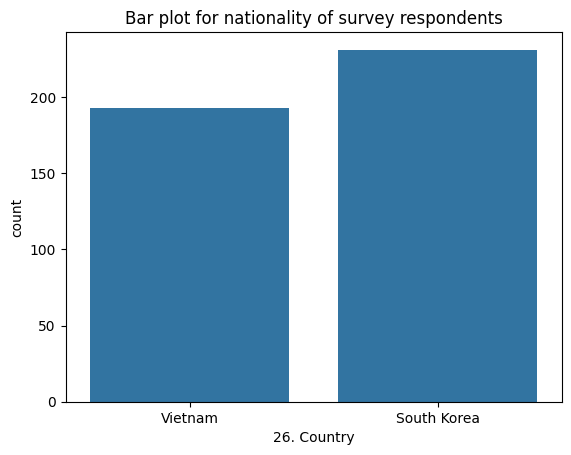

In [136]:
# display counts for Vietnam, South Korea
sns.countplot(df, x = '26. Country')
plt.title('Bar plot for nationality of survey respondents')

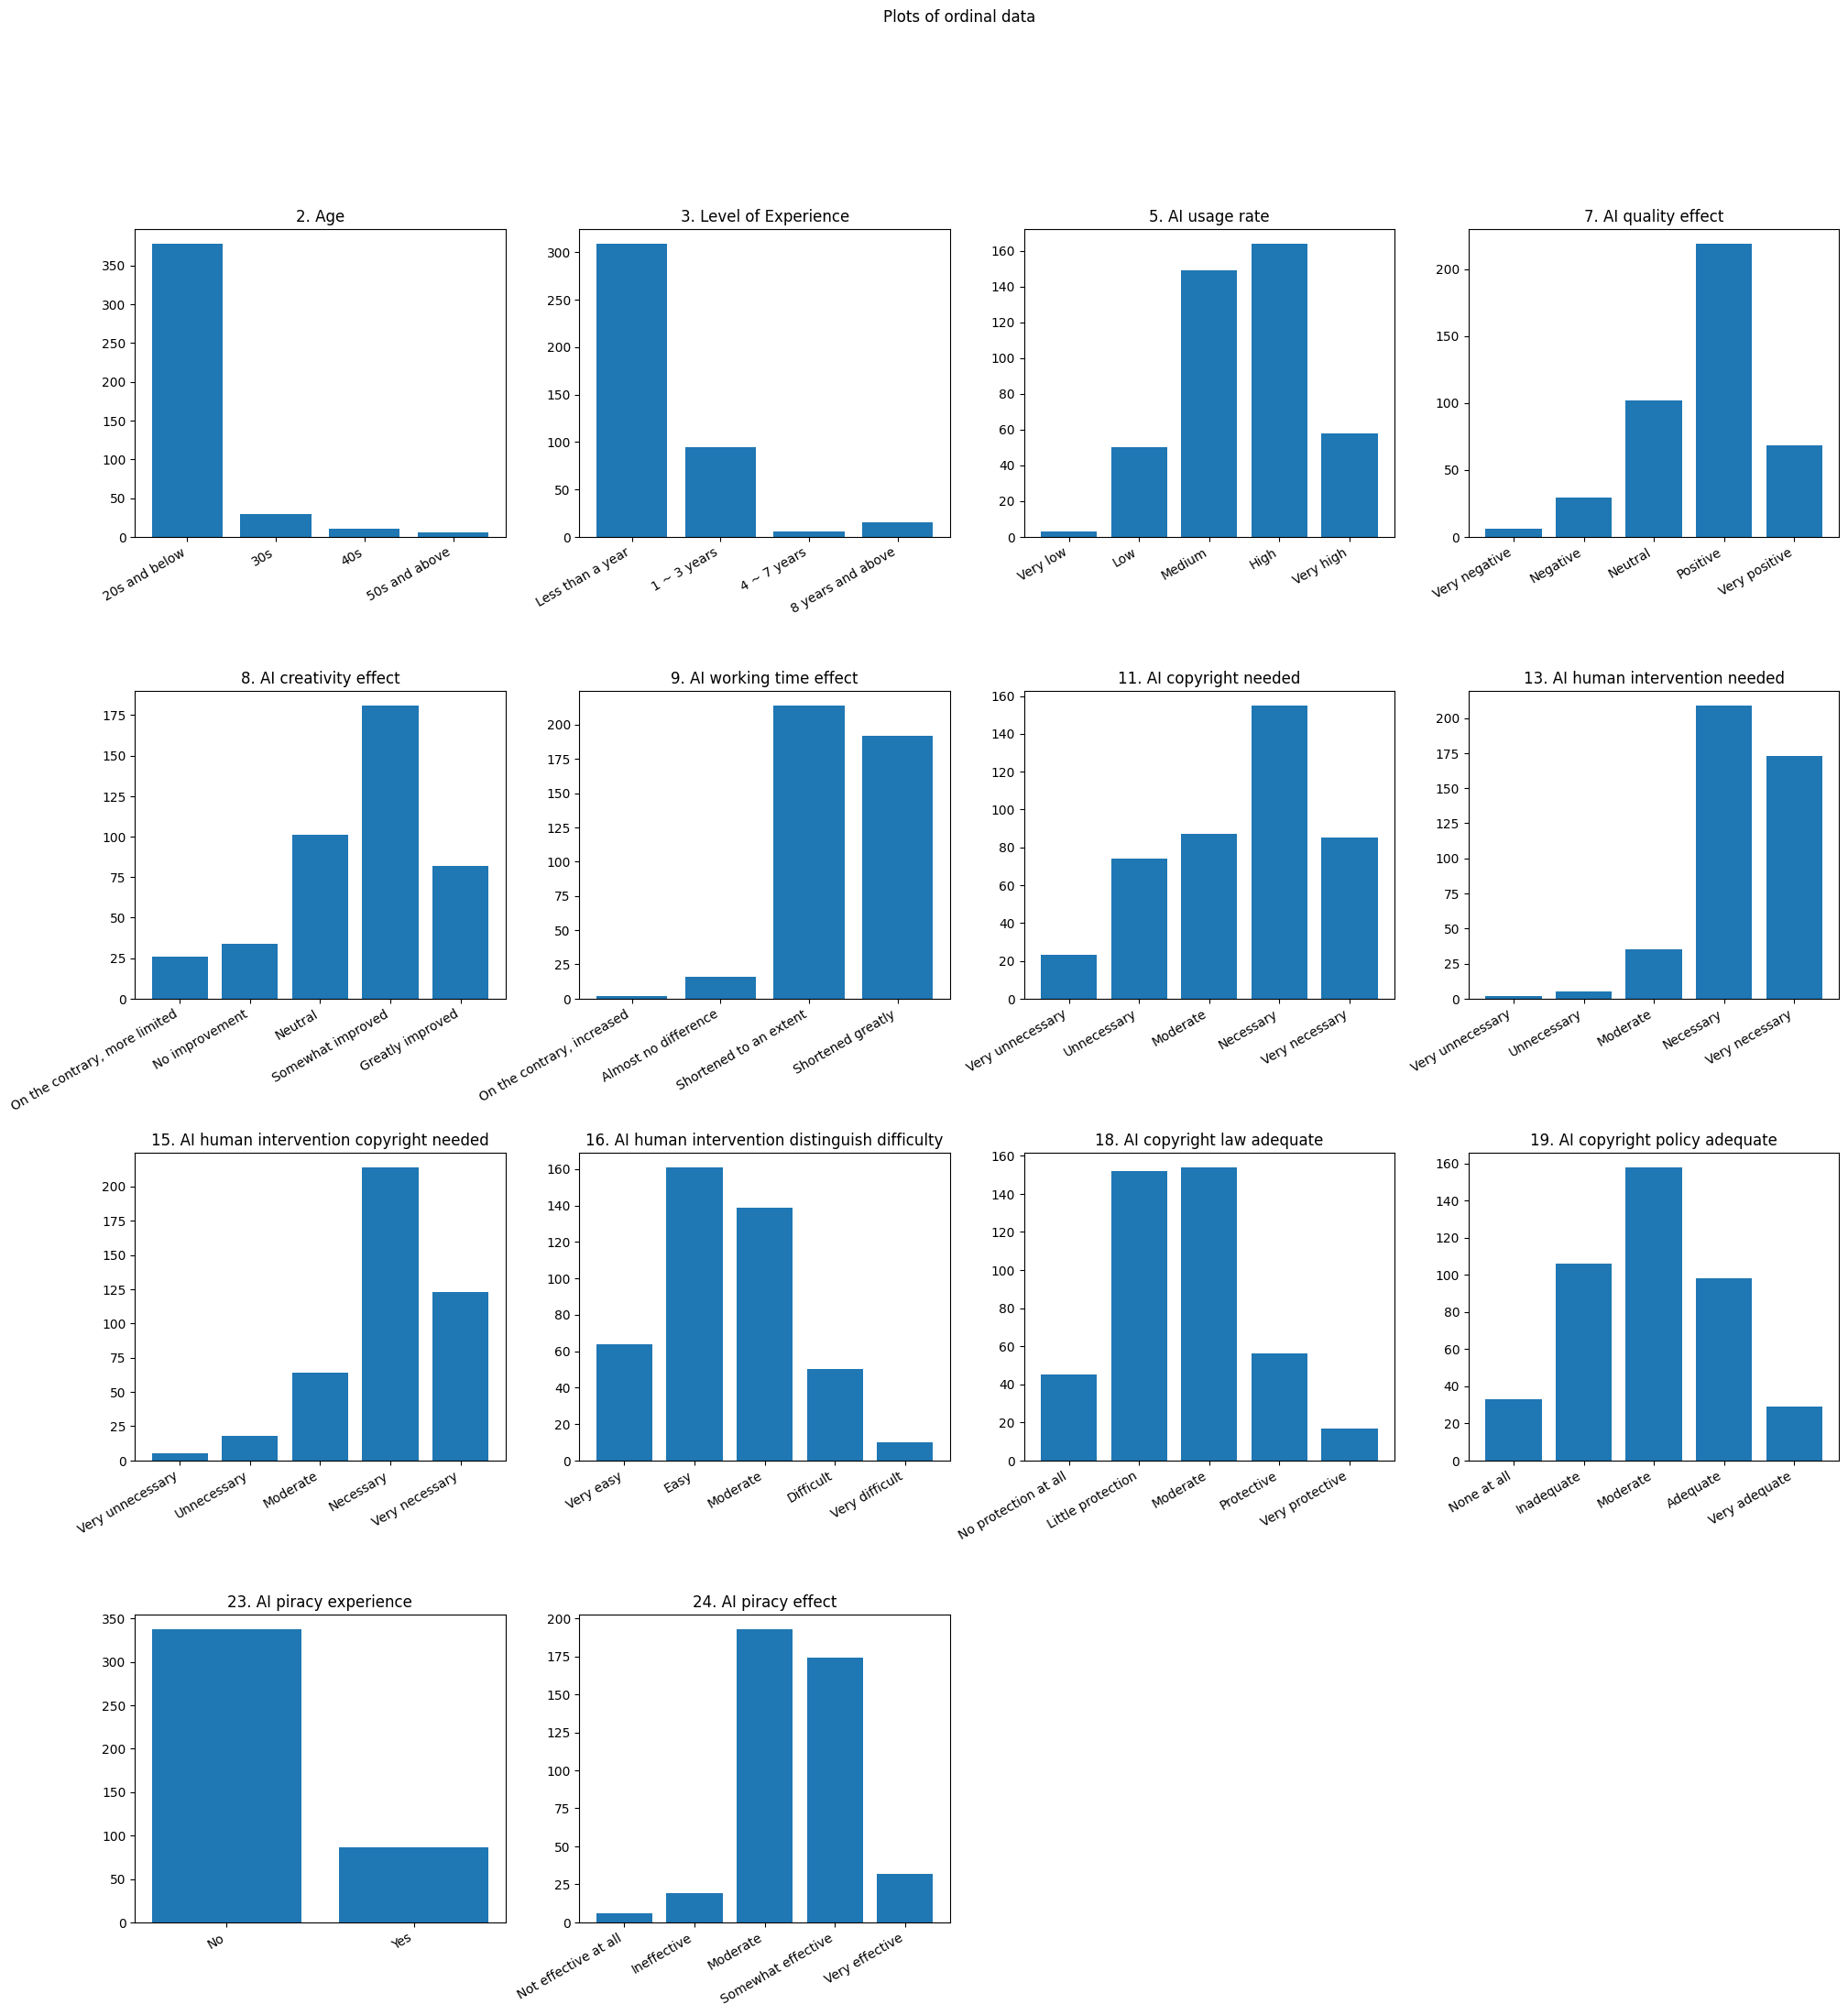

In [168]:
# convert relevant columns to ordinal data, plot

plt.figure(figsize = (24, 24))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Plots of ordinal data')
for i in range(len(ord_list)):
    cat = pd.api.types.CategoricalDtype(categories = ord_list[i], ordered = True)
    df[ord_cols[i]] = df[ord_cols[i]].astype(cat)
    ax = plt.subplot(4, 4, i + 1)
    plt.bar(x = df.groupby(ord_cols[i], observed = False).size().index, height = df.groupby(ord_cols[i], observed = False).size().values)
    ax.set_title(ord_cols[i])
    #ax.bar_label(df.groupby(ord_cols[i], observed = False).size().values)
    plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'right')

In [138]:
# convert relevant columns to ordinal

# enc = OrdinalEncoder(categories=[['20s and below', '30s', '40s', '50s and above'], ['Less than a year', '1 ~ 3 years', '4 ~ 7 years', '8 years and above'], ['Very low', 'Low', 'Medium', 'High', 'Very high'], ['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive'], ['On the contrary, more limited', 'No improvement', 'Neutral', 'Somewhat improved', 'Greatly improved'], ['On the contrary, working time increased', 'Almost no difference', 'Shortened to an extent', 'Shortened greatly'], ['Very unnecessary', 'Unnecessary', 'Moderate', 'Necessary', 'Very necessary'], ['Very unnecessary', 'Unnecessary', 'Moderate', 'Necessary', 'Very necessary'], ['Very unnecessary', 'Unnecessary', 'Moderate', 'Necessary', 'Very necessary'], ['Very unnecessary', 'Unnecessary', 'Moderate', 'Necessary', 'Very necessary'], ['No protection at all', 'Little protection', 'Moderate', 'Protective', 'Very protective'], ['None at all', 'Inadequate', 'Moderate', 'Adequate', 'Very adequate'], ['Not effective at all', 'Ineffective', 'Moderate', 'Somewhat effective', 'Very effective']])
# df.iloc[:, [1, 2, 4, 6, 7, 8, 10, 12, 14, 15, 17, 18, 23]] = enc.fit_transform(df.iloc[:, [1, 2, 4, 6, 7, 8, 10, 12, 14, 15, 17, 18, 23]])

In [139]:
# One-Hot Encode relevant categorical columns

# for column in cat_cols:
#     df = pd.concat([df.drop(column, axis = 1), df[column].str.get_dummies(sep = ", ").add_prefix(f'{column}_')], axis = 1)

In [169]:
col4_values_list = ['Machine Learning', 'Deep Learning', 'Natural Language Processing', 'Computer Vision', 'Not sure']
col6_values_list = ['Brainstorming', 'Character design and creation', 'Story generation', 'Background and details', 'QA and debugging', 'Not sure']
col10_values_list = ['Lack of data', 'Low accuracy of AI models', 'Legal/ethical issues', 'Cost and accessibility of AI', 'Copyright issues', 'Creativity issues']
col12_values_list = ['AI developer', 'AI platform', r'AI user \(writer or designer\)', 'AI itself', r'Co-owned \(AI developer and user\)', 'Nobody', 'Copyright holder of training data']
col14_values_list = ['Character design', 'Story development', 'Level design', r'\(Game\) Predicting user behavior', r'\(Game\) Creating live game content', r'\(Webtoons / Comics\) Auto-coloring', r'\(Webtoons / Comics\) Background generation', r'\(Webtoons / Comics\) Creating dialogue']
col17_values_list = ['Determining copyright status', 'Distinguishing between original and AI-generated content', 'Possibility of copyright infringement', 'Problems with data used by AI models']
col20_values_list = [r'Clarifying copyright status in AI works \(through a new theoretical basis\)', 'New laws on AI-generated content', 'Amending existing copyright laws', 'International cooperation and standardization']
col21_values_list = ['Issues with determining the copyright holder of AI-generated content', 'Lack of legal recognition regarding the creativity of AI', 'Problems with creativity in AI-generated content', 'Copyright issues with AI training data']
col25_values_list = ['Ability to analyze large-scale data', 'Fast detection speed', 'Minimizing human error', 'Cost-effective']

cat_list = [col4_values_list, col6_values_list, col10_values_list, col12_values_list, col14_values_list, col17_values_list, col20_values_list, col21_values_list, col25_values_list]

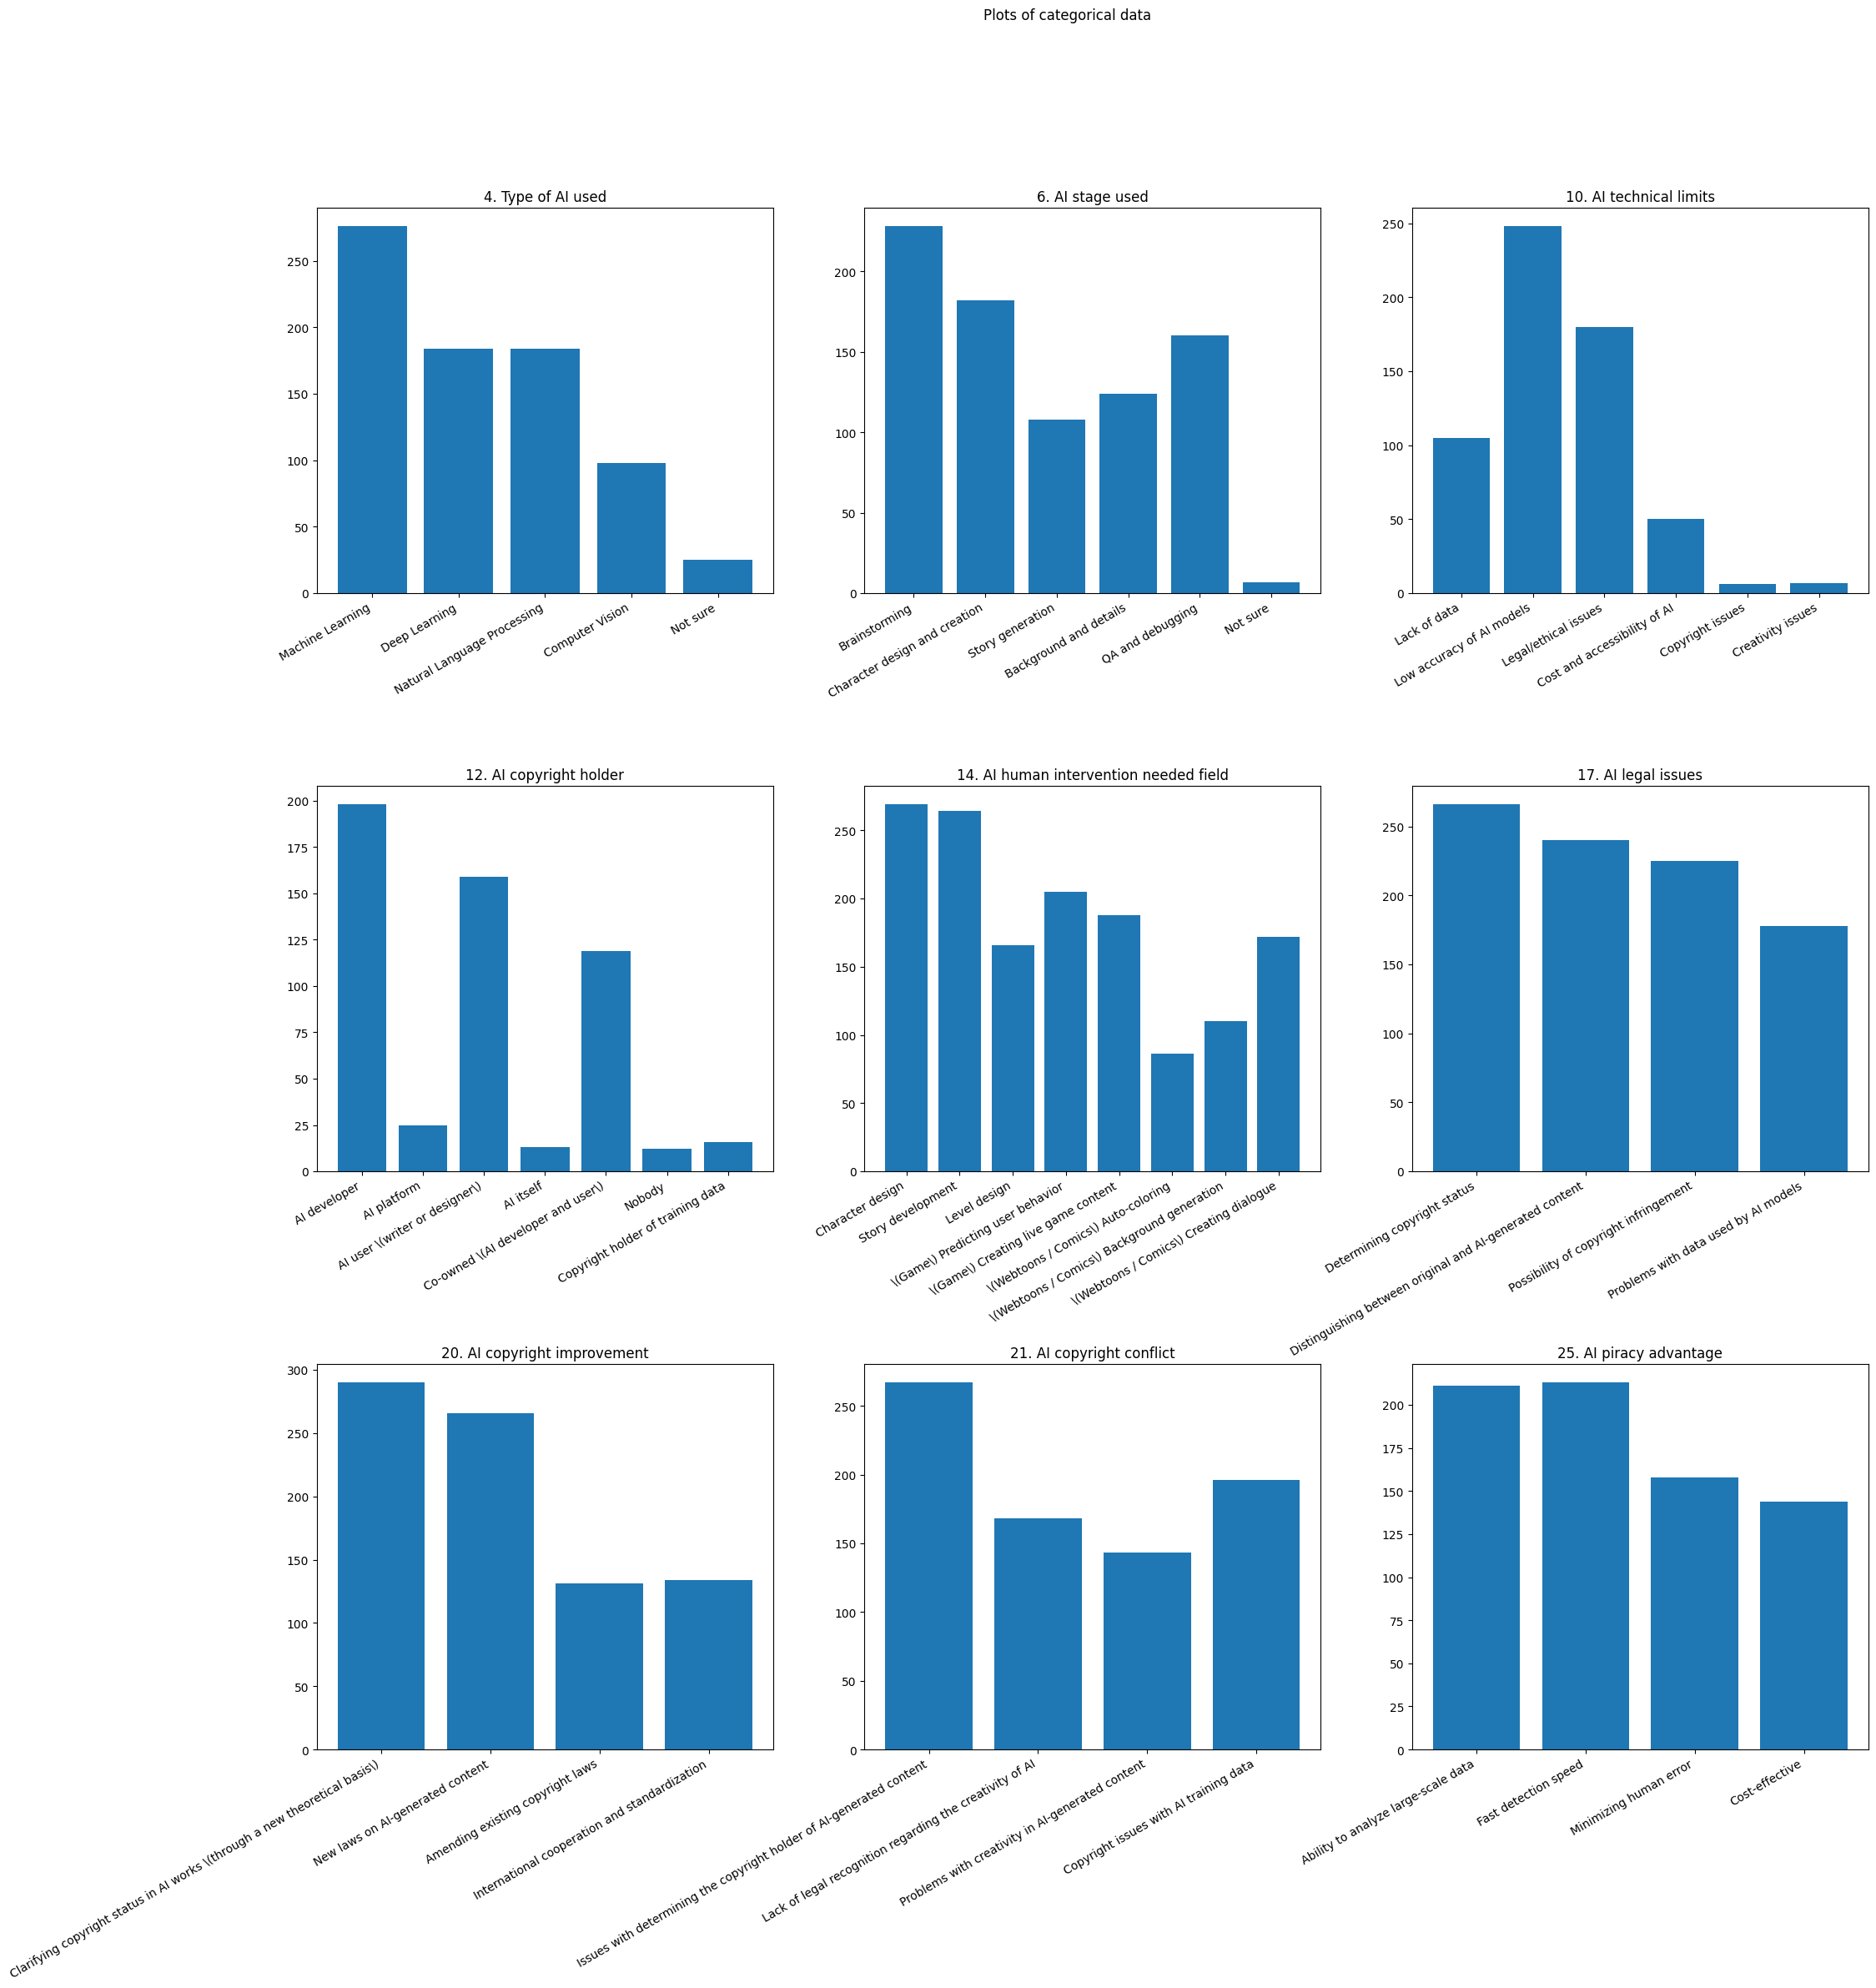

In [141]:
# plot categorical data with multiple answers enabled

plt.figure(figsize = (24, 24))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Plots of categorical data')
for i in range(len(cat_list)):
    values = list()
    for k in range(len(cat_list[i])):
        values.append(np.sum(df[cat_cols[i]].str.contains(cat_list[i][k])))
    ax = plt.subplot(3, 3, i + 1)
    plt.bar(x = cat_list[i], height = values)
    ax.set_title(cat_cols[i])
    plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'right')

C:\Users\GwanHyeon Koh\AppData\Local\Temp\ipykernel_14140\594123389.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels1)
C:\Users\GwanHyeon Koh\AppData\Local\Temp\ipykernel_14140\594123389.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels2)


[Text(0, 0, 'Providing\nclear\nlegal\nstandards\nto\nresolve\ndisputes'),
 Text(1, 0, 'Interpret\ning and\napplying\nexisting\nlaws'),
 Text(2, 0, 'Creating\nnew laws\nand regul\nations'),
 Text(3, 0, 'Resolving\ndisputes\nthrough i\nnternatio\nnal coope\nration'),
 Text(4, 0, 'No need'),
 Text(5, 0, 'Not sure')]

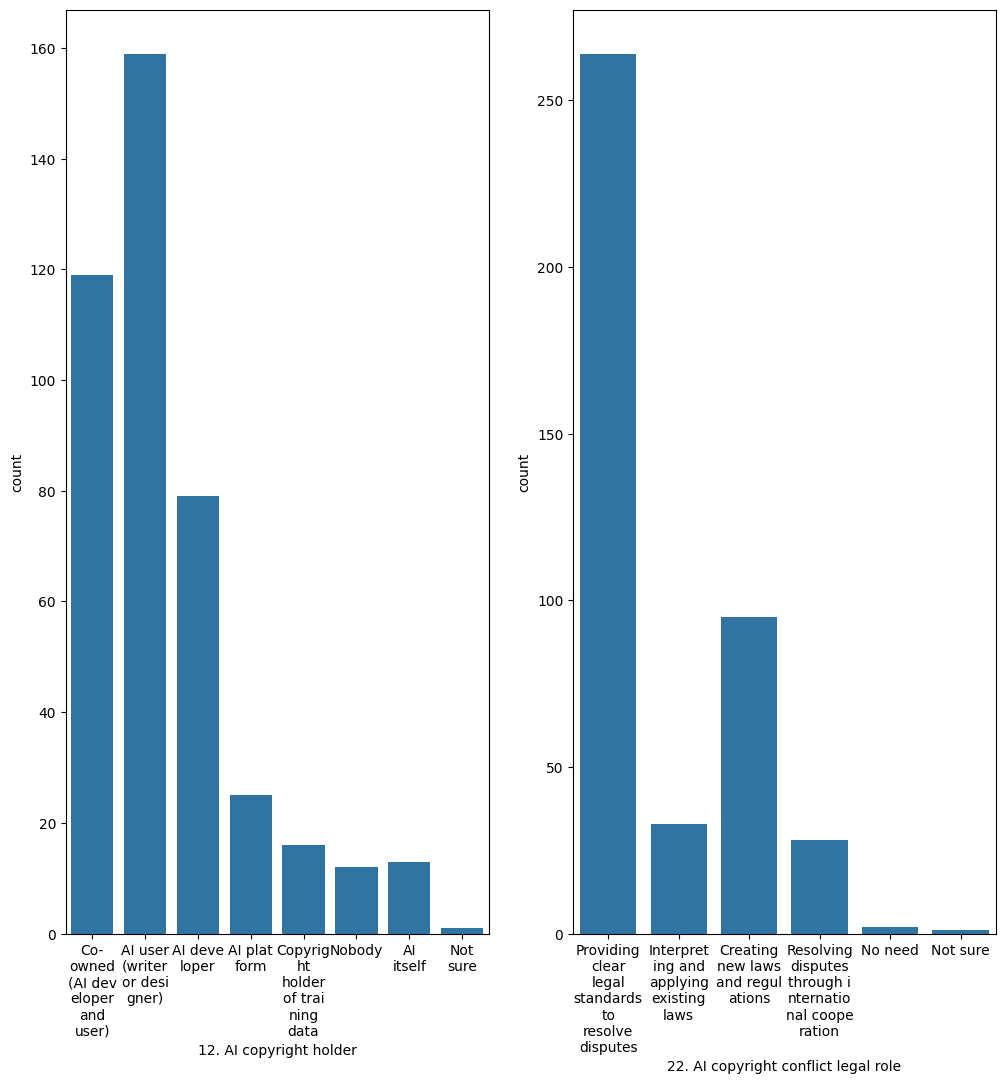

In [142]:
# plots for misc data

plt.figure(figsize = (12, 12))
ax1 = plt.subplot(121)
sns.countplot(data = df, x = '12. AI copyright holder')
labels1 = [textwrap.fill(label.get_text(), 7) for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels1)
#plt.xticks(rotation = 90)
ax2 = plt.subplot(122)
sns.countplot(data = df, x = '22. AI copyright conflict legal role')
labels2 = [textwrap.fill(label.get_text(), 9) for label in ax2.get_xticklabels()]
ax2.set_xticklabels(labels2)
#plt.xticks(rotation = 90)

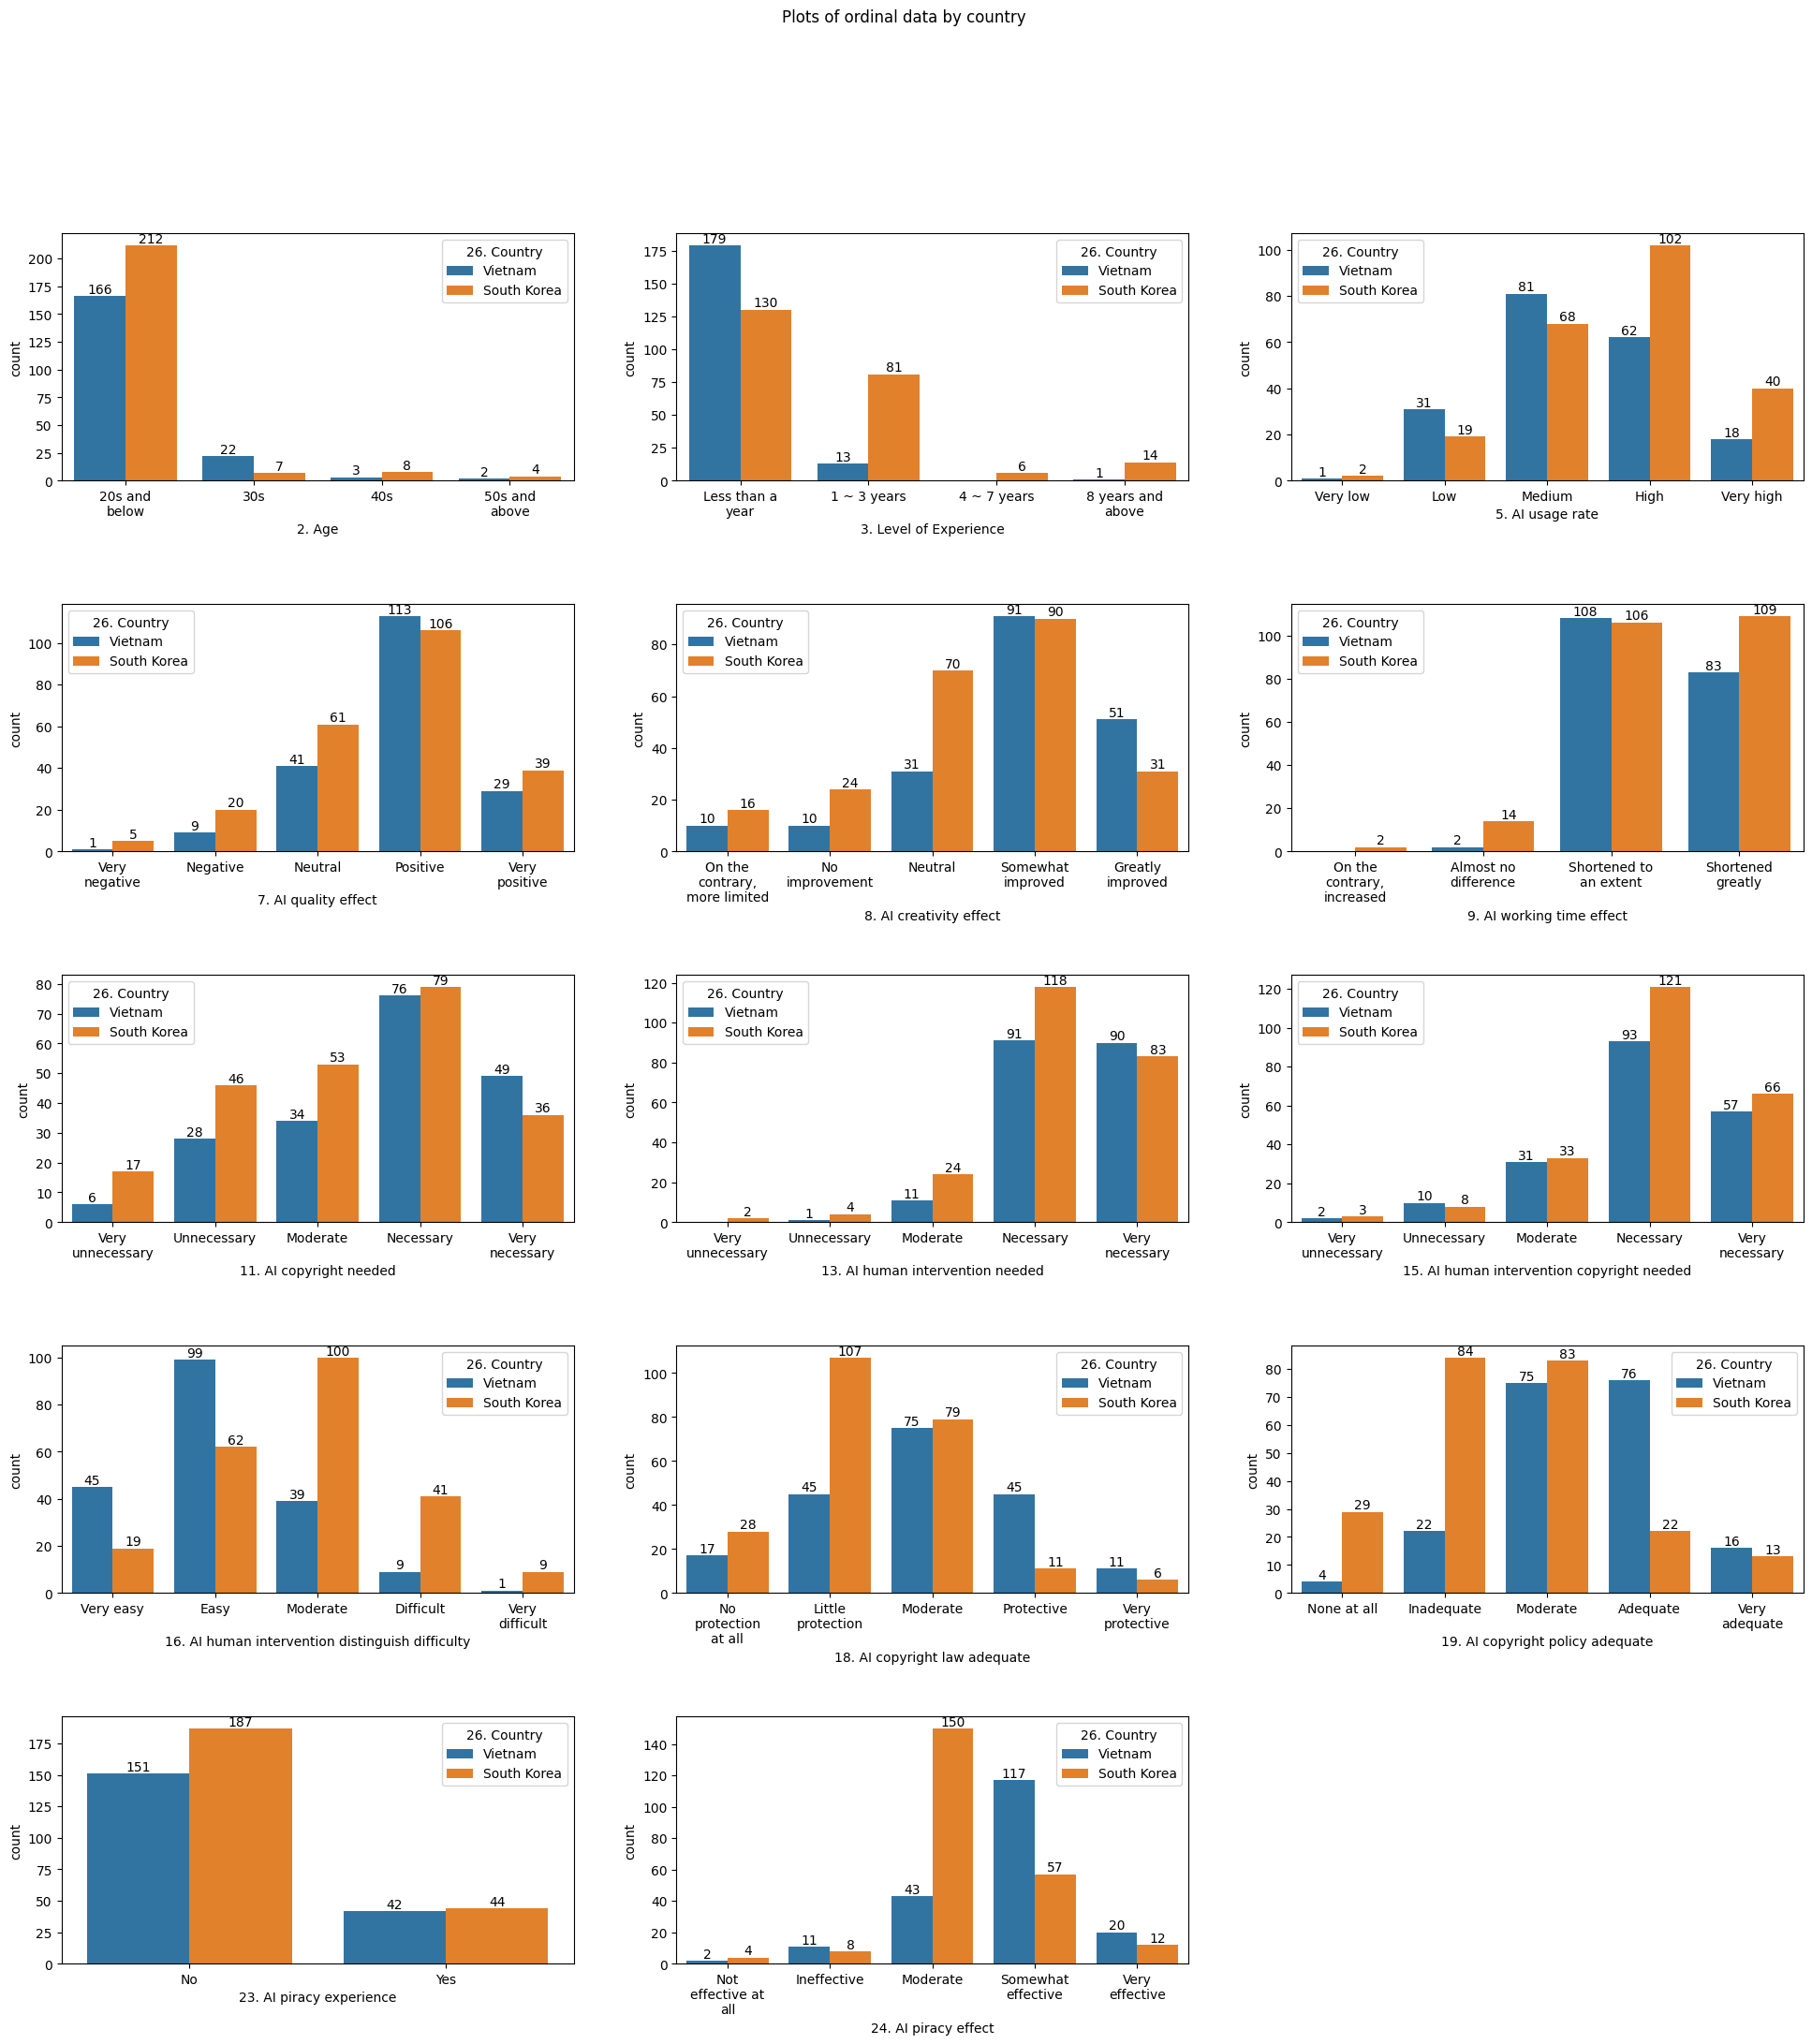

In [143]:
# plot ordinal data by country

plt.figure(figsize = (24, 24))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Plots of ordinal data by country')
for i in range(len(ord_list)):
    #new_df = df
    ax = plt.subplot(5, 3, i + 1)
    sns.countplot(data = df, x = ord_cols[i], hue = '26. Country')
    labels = [textwrap.fill(label.get_text(), 12) for label in ax.get_xticklabels()]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    for container in ax.containers:
        ax.bar_label(container)
    #plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'right')

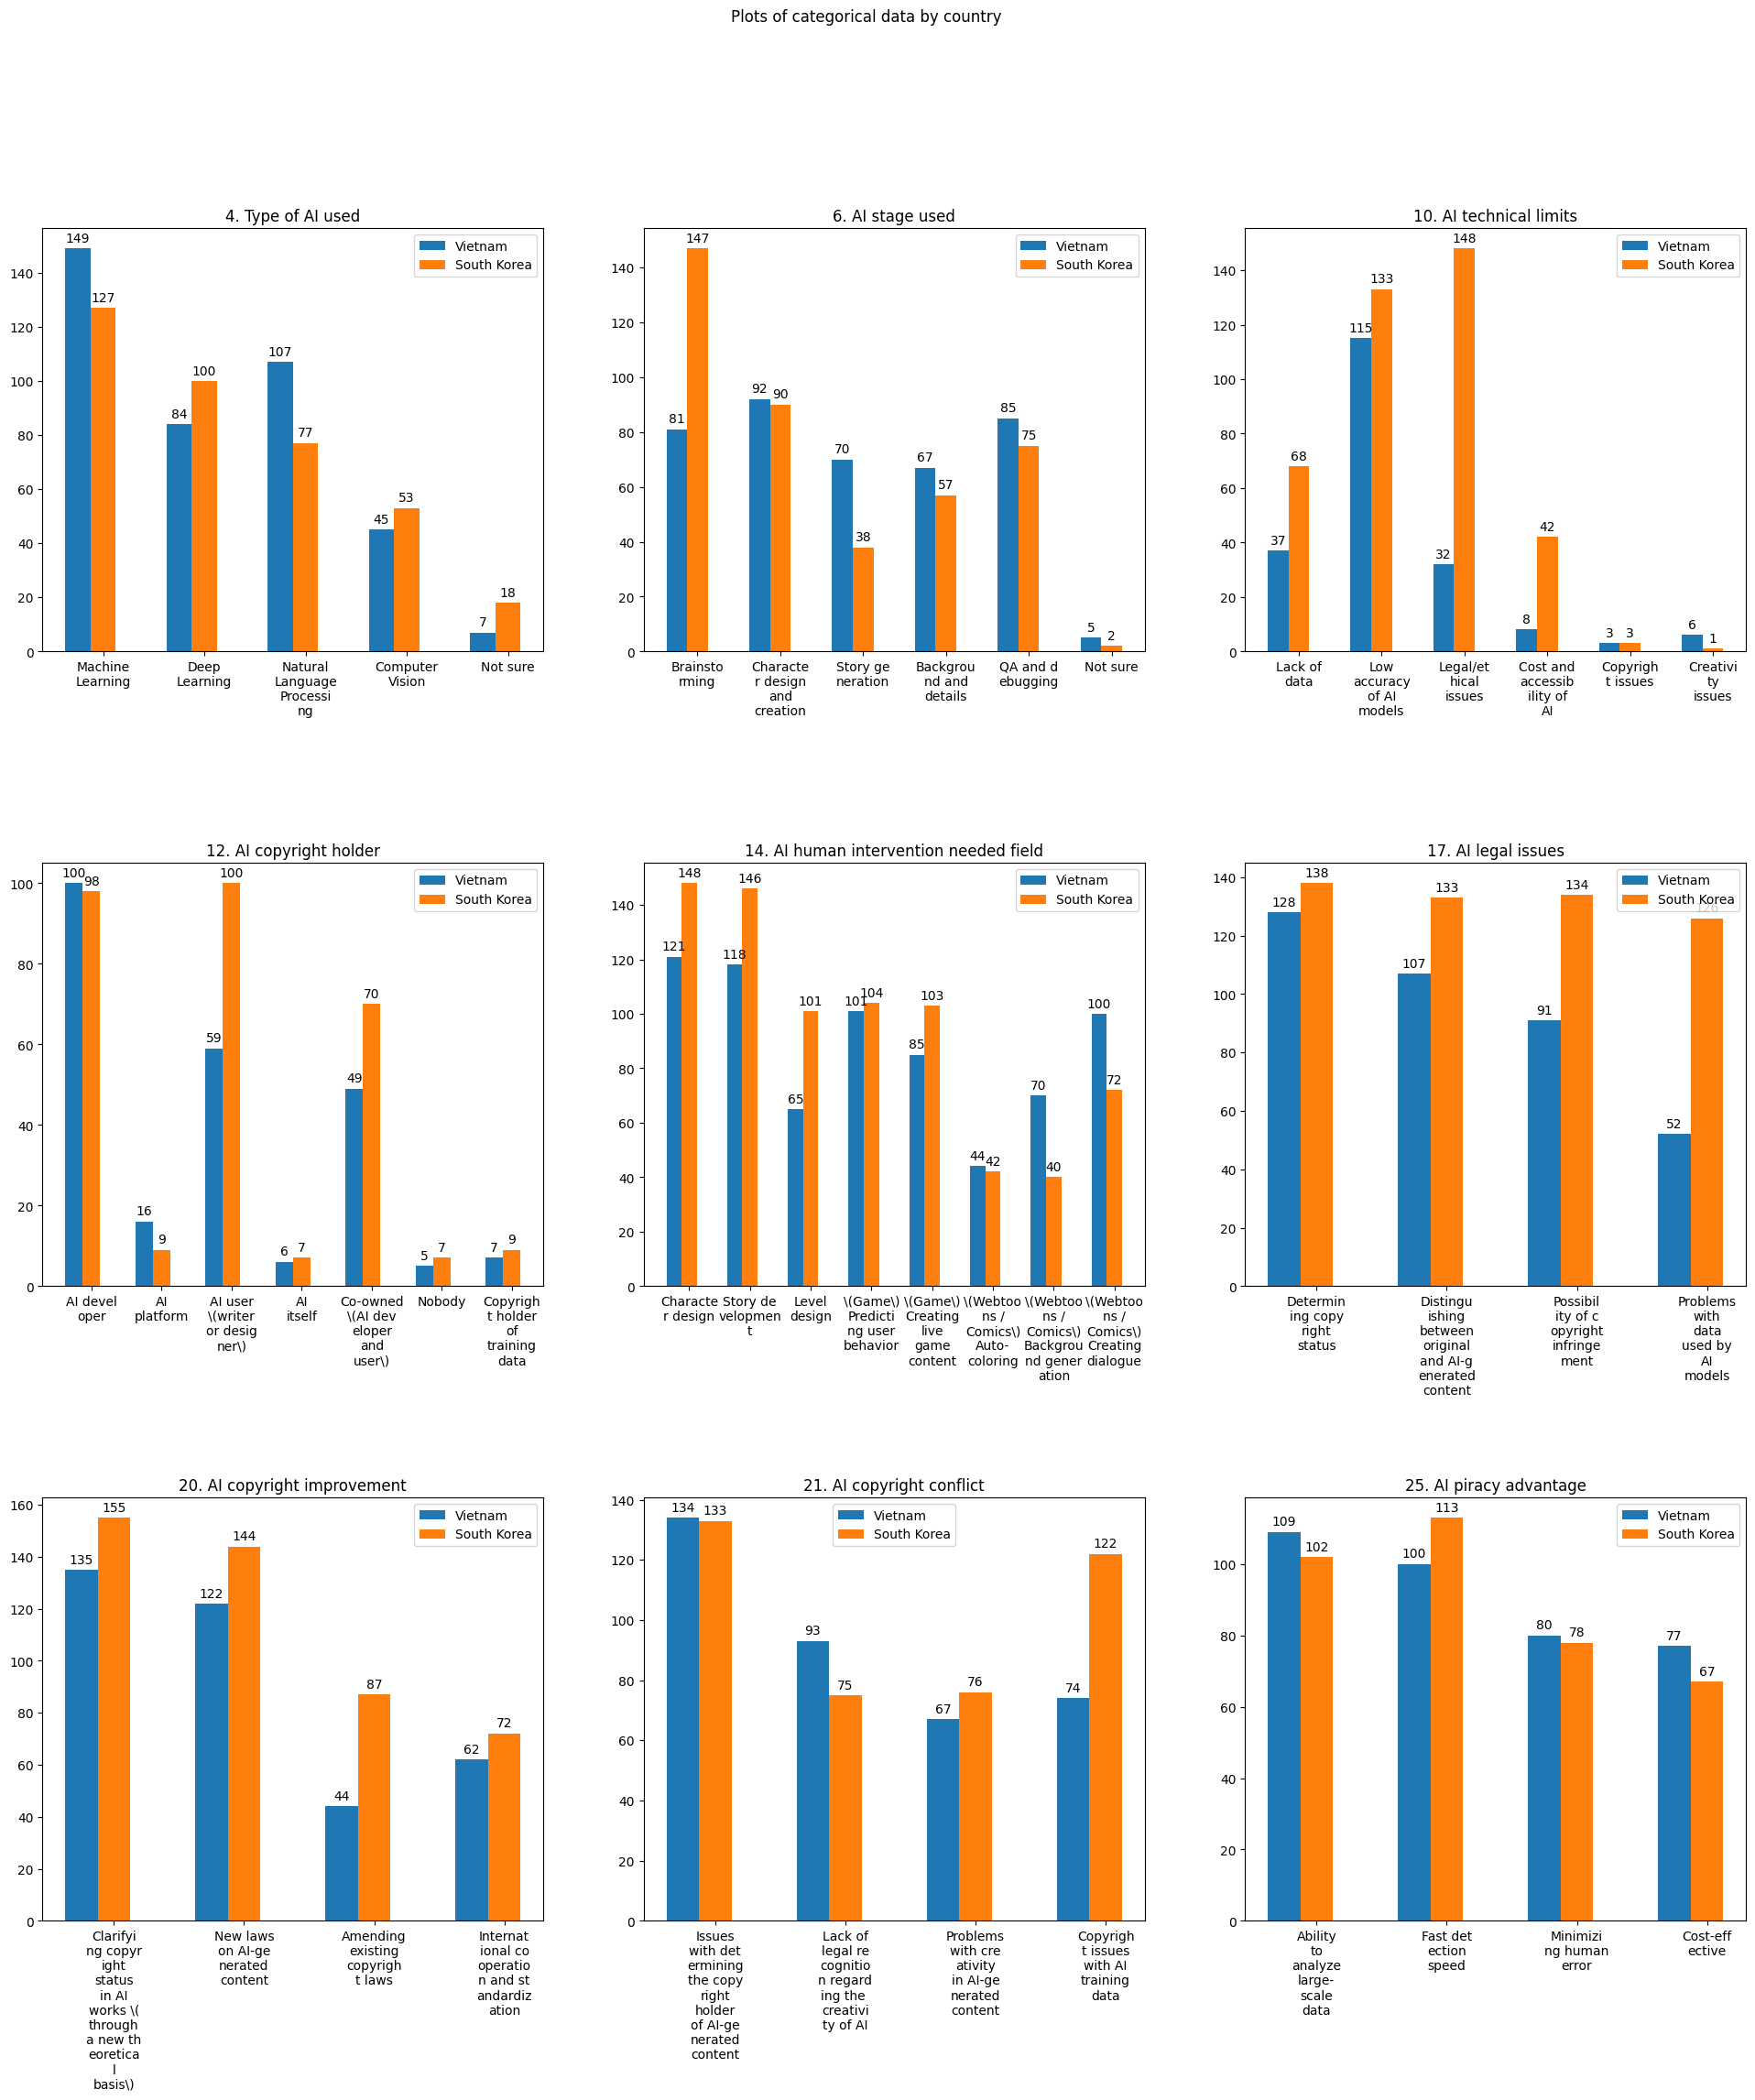

In [144]:
# plot categorical data with multiple answers enabled by country

plt.figure(figsize = (24, 24))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Plots of categorical data by country')
for i in range(len(cat_list)):
    # cat_dict = {cat_list[i][k]: (np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'Vietnam')), np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'South Korea'))) for k in range(len(cat_list[i]))}
    
    cat_dict = dict()
    cat_dict['Vietnam'] = tuple(np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'Vietnam')) for k in range(len(cat_list[i])))
    cat_dict['South Korea'] = tuple(np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'South Korea')) for k in range(len(cat_list[i])))

    x = np.arange(len(cat_list[i]))
    width = 0.25
    multiplier = 0

    ax = plt.subplot(3, 3, i + 1)
    for country, values in cat_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label = country)
        ax.bar_label(rects, padding = 3)
        multiplier += 1
    
    ax.set_xticks(x + width, cat_list[i])
    labels = [textwrap.fill(label.get_text(), 8) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title(cat_cols[i])
    ax.legend()


In [152]:
# get totals for Vietnam, South Korea
vn_total = len(df[df['26. Country'] == 'Vietnam'])
kr_total = len(df[df['26. Country'] == 'South Korea'])

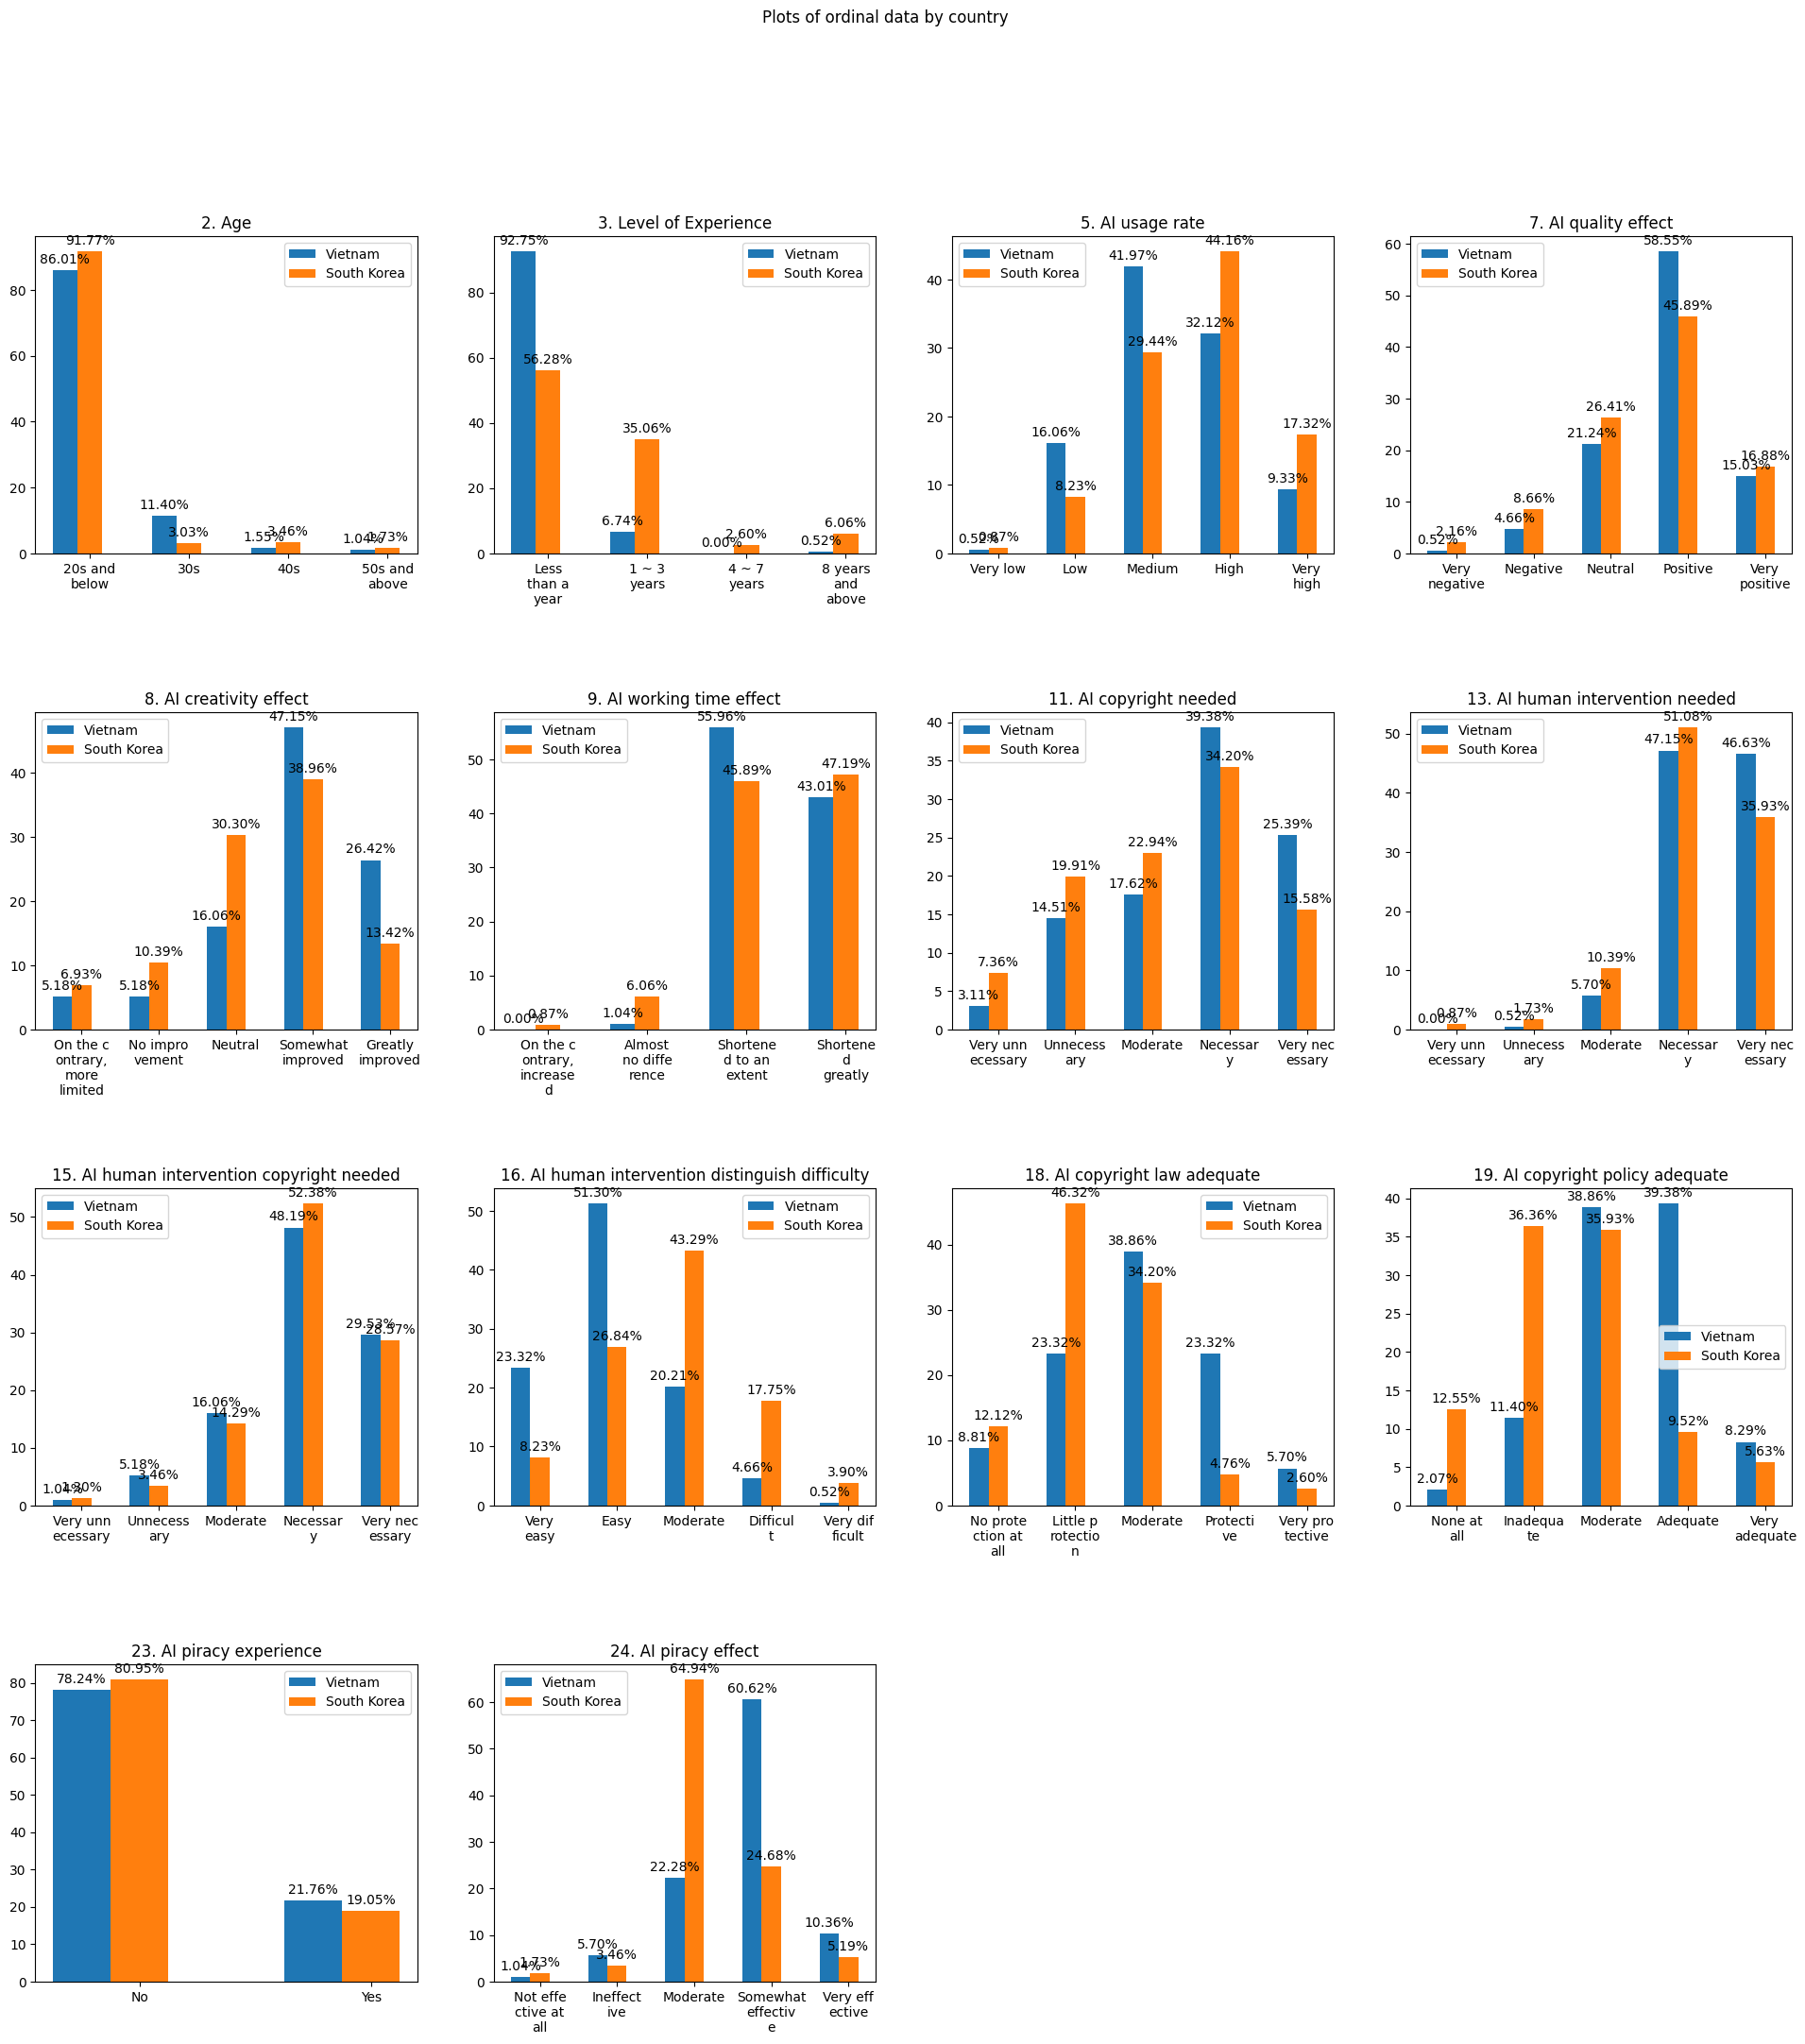

In [221]:
# plot ordinal data by country normalized by count per country for easier visualization

plt.figure(figsize = (24, 24))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Plots of ordinal data by country')
for i in range(len(ord_list)):
    ord_dict = dict()
    ord_dict['Vietnam'] = tuple((df.groupby([ord_cols[i], '26. Country'], observed = False).size().values[2 * k + 1])/vn_total * 100 for k in range(len(ord_list[i])))
    ord_dict['South Korea'] = tuple((df.groupby([ord_cols[i], '26. Country'], observed = False).size().values[2 * k])/kr_total * 100 for k in range(len(ord_list[i])))

    x = np.arange(len(ord_list[i]))
    width = 0.25
    multiplier = 0

    ax = plt.subplot(4, 4, i + 1)
    for country, values in ord_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label = country)
        ax.bar_label(rects, fmt = '%.2f%%', padding = 3)
        multiplier += 1
    
    ax.set_xticks(x + width, ord_list[i])
    labels = [textwrap.fill(label.get_text(), 8) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title(ord_cols[i])
    ax.legend()

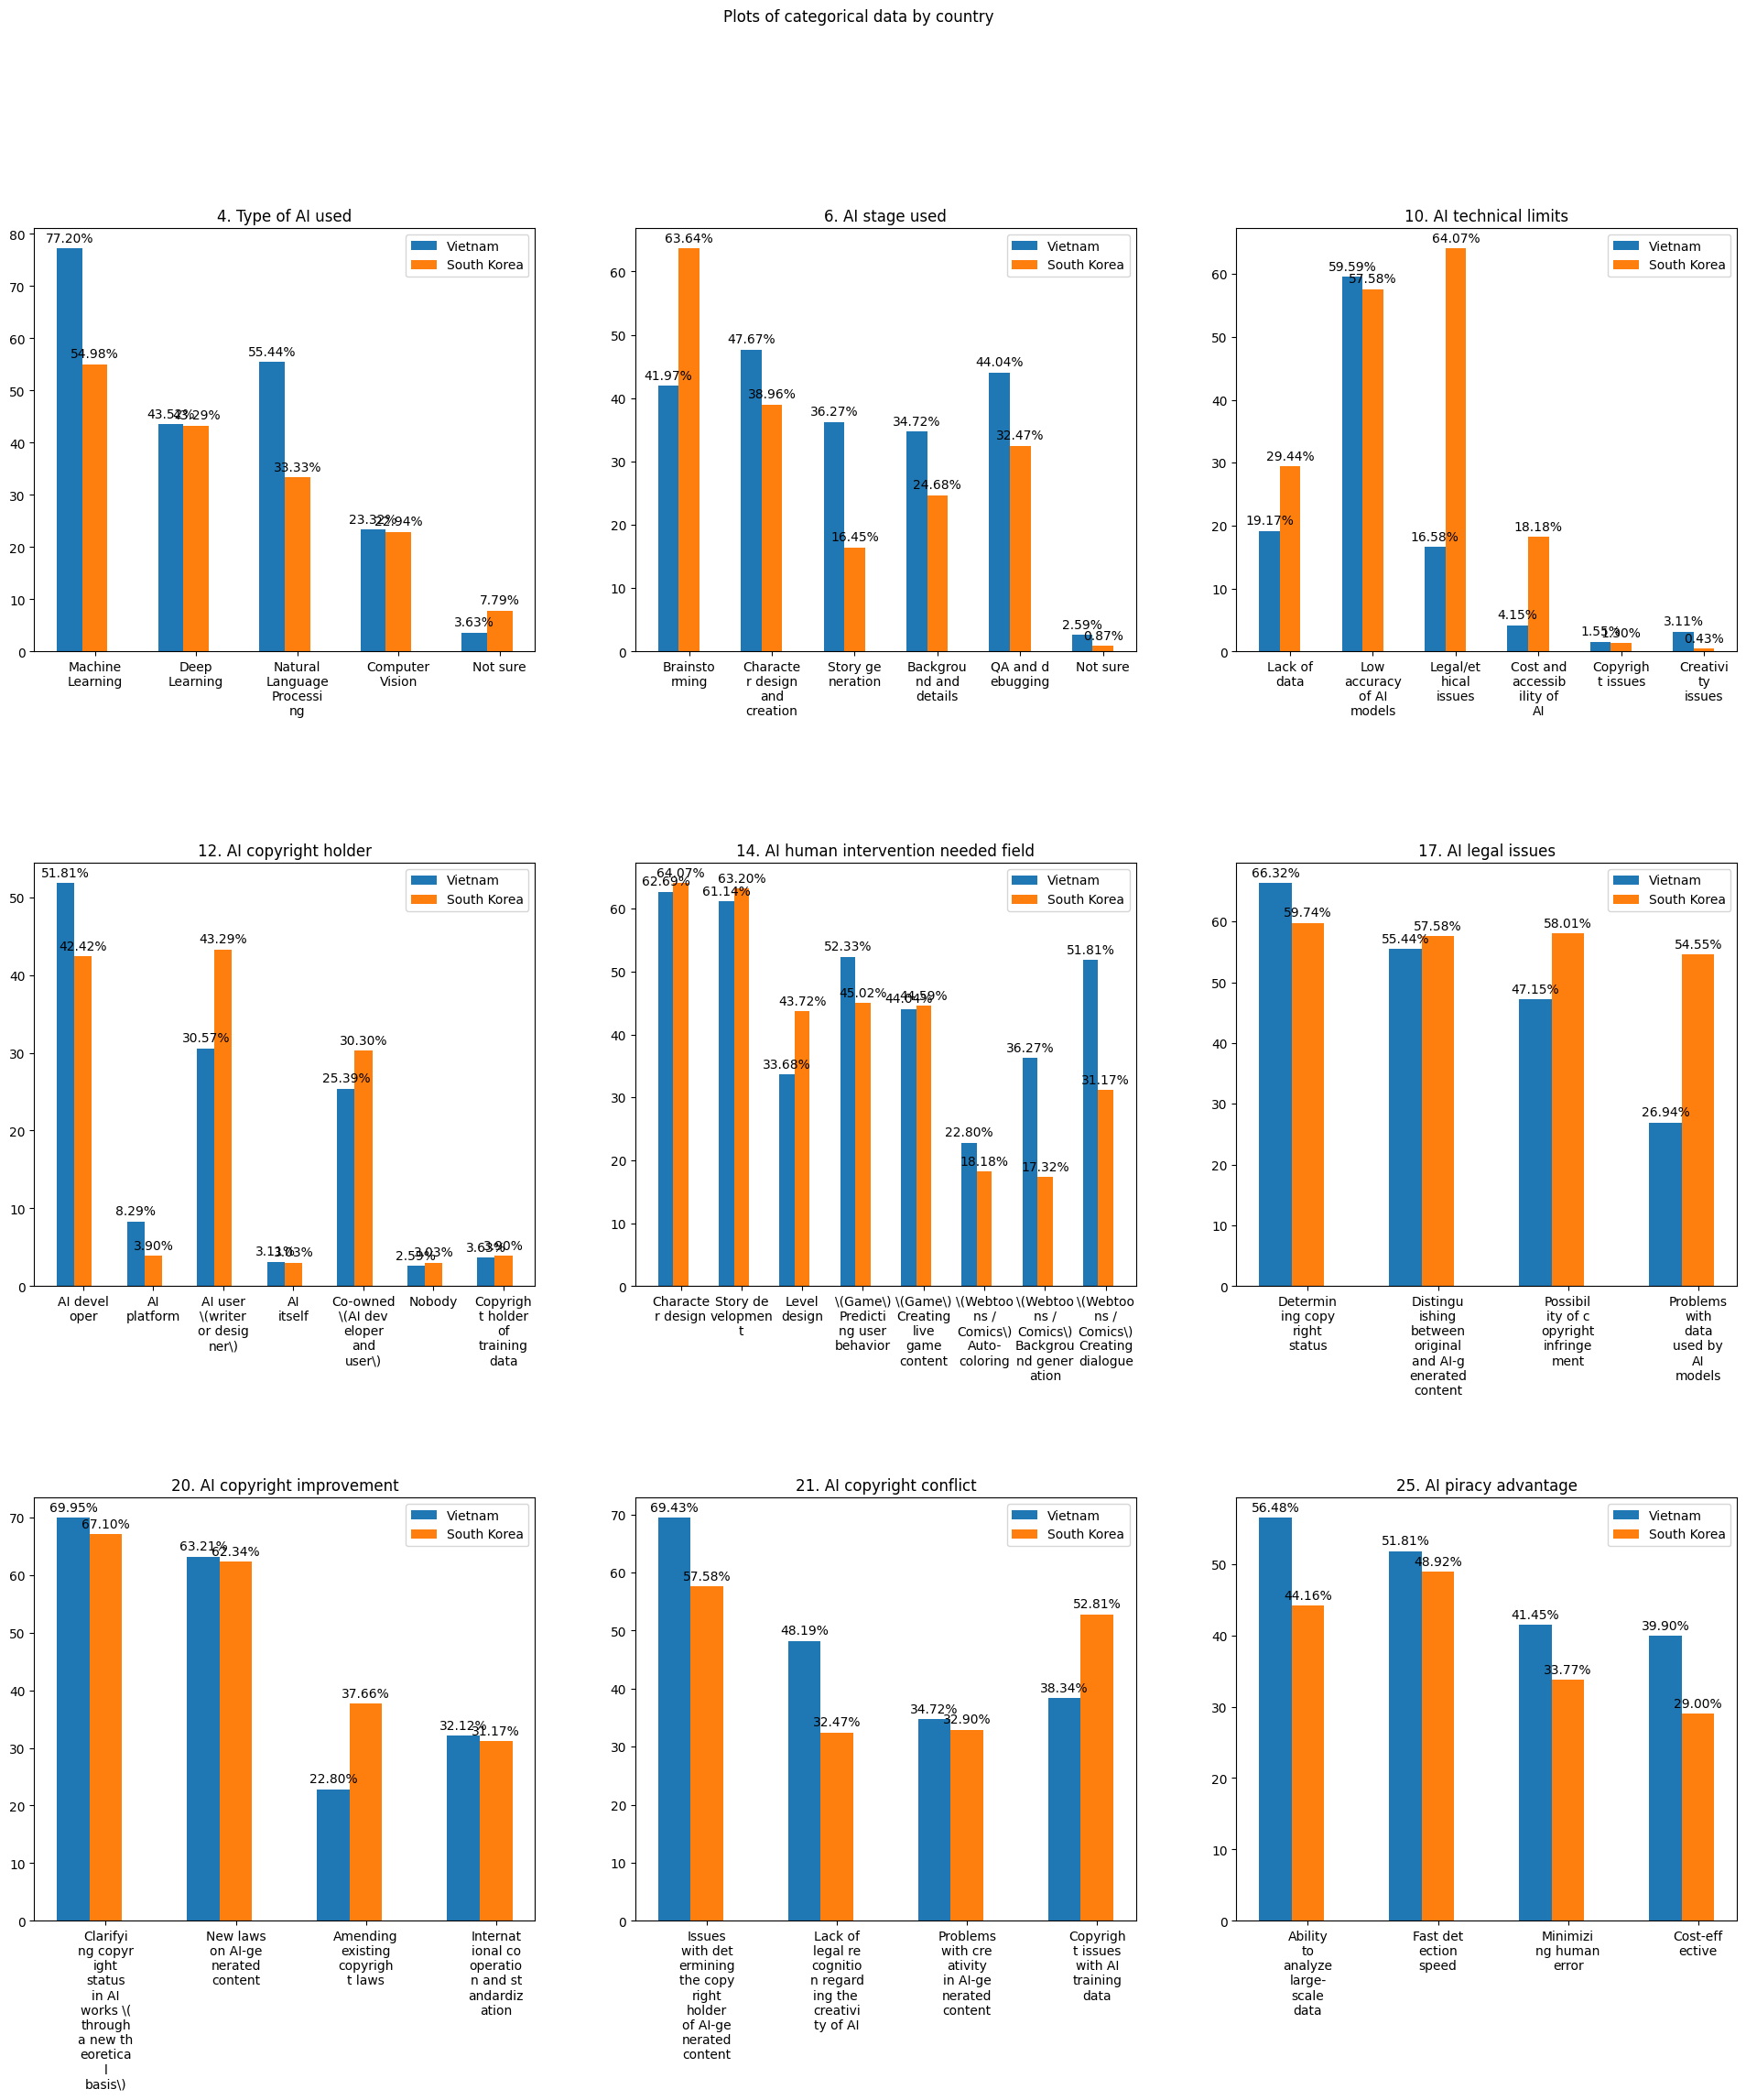

In [219]:
# plot categorical data by country normalized by count per country for easier visualization

plt.figure(figsize = (24, 24))
plt.subplots_adjust(hspace = 0.5)
plt.suptitle('Plots of categorical data by country')
for i in range(len(cat_list)):
    # cat_dict = {cat_list[i][k]: (np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'Vietnam')), np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'South Korea'))) for k in range(len(cat_list[i]))}
    
    cat_dict = dict()
    cat_dict['Vietnam'] = tuple(np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'Vietnam'))/vn_total * 100 for k in range(len(cat_list[i])))
    cat_dict['South Korea'] = tuple(np.sum((df[cat_cols[i]].str.contains(cat_list[i][k])) & (df['26. Country'] == 'South Korea'))/kr_total * 100 for k in range(len(cat_list[i])))

    x = np.arange(len(cat_list[i]))
    width = 0.25
    multiplier = 0

    ax = plt.subplot(3, 3, i + 1)
    for country, values in cat_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label = country)
        ax.bar_label(rects, fmt = '%.2f%%', padding = 3)
        multiplier += 1
    
    ax.set_xticks(x + width, cat_list[i])
    labels = [textwrap.fill(label.get_text(), 8) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title(cat_cols[i])
    ax.legend()

In [ ]:
# Change ordinal data to numeric for statistical tests
new_df = df
for column in ord_cols:
    new_df[column] = new_df[column].cat.codes

In [147]:
# basic statistical tests for EDA

# Mann-Whitney test for Country & AI usage rate
_, p_Country_AIuse = mannwhitneyu((new_df['5. AI usage rate'][new_df['26. Country'] == 'Vietnam']), (new_df['5. AI usage rate'][new_df['26. Country'] == 'South Korea']), nan_policy = 'omit')
print(f'p-value for Mann-Whitney test between country and AI usage rate: {p_Country_AIuse}')

# Mann-Whitney test for Country & AI copyright needed
_, p_Country_AIcopyr = mannwhitneyu((df['11. AI copyright needed'][new_df['26. Country'] == 'Vietnam']), (new_df['11. AI copyright needed'][new_df['26. Country'] == 'South Korea']), nan_policy = 'omit')
print(f'p-value for Mann-Whitney test between country and perception on the necessity of copyright for AI-generated content: {p_Country_AIcopyr}')

# Mann-Whitney test for Country & AI human intervention copyright needed
_, p_Country_AI_human_copyr = mannwhitneyu((new_df['15. AI human intervention copyright needed'][new_df['26. Country'] == 'Vietnam']), (new_df['15. AI human intervention copyright needed'][new_df['26. Country'] == 'South Korea']), nan_policy = 'omit')
print(f'p-value for Mann-Whitney test between country and perception on the necessity of copyright for human intervention in AI-generated content: {p_Country_AI_human_copyr}')

# Mann-Whitney test for Country & AI copyright law adequate
_, p_AI_copyr_law = mannwhitneyu((new_df['18. AI copyright law adequate'][new_df['26. Country'] == 'Vietnam']), (new_df['18. AI copyright law adequate'][new_df['26. Country'] == 'South Korea']), nan_policy = 'omit')
print(f'p-value for Mann-Whitney test between country and perception on the adequacy of copyright laws for AI-generated content in respective countries: {p_AI_copyr_law}')

# Mann-Whitney test for Country & AI copyright policy adequate
_, p_AI_copyr_pol = mannwhitneyu((new_df['19. AI copyright policy adequate'][new_df['26. Country'] == 'Vietnam']), (new_df['19. AI copyright policy adequate'][new_df['26. Country'] == 'South Korea']), nan_policy = 'omit')
print(f'p-value for Mann-Whitney test between country and perception on the adequacy of academic and policy efforts for AI-generated content in respective countries: {p_AI_copyr_pol}')

# Chi-square test for Country & AI piracy experience
res = chi2_contingency(pd.crosstab(new_df['26. Country'], new_df['23. AI piracy experience']))
print(f'p-value for Chi-square test of independence between country and experience with AI-based piracy detection systems: {res.pvalue}')

# Kruskal-Wallis test for AI usage & AI copyright needed
AI_use_AI_copyr_list = [new_df['11. AI copyright needed'][new_df['5. AI usage rate'] == i].to_list() for i in range(new_df['5. AI usage rate'].nunique())]
print(f'p-value for Kruskal-Wallis test between AI usage rates and perception on the necessity of copyright for AI-generated content: {kruskal(*AI_use_AI_copyr_list)[1]}')

# Kruskal-Wallis test for AI usage & AI quality effect
AI_use_AI_qual_list = [new_df['7. AI quality effect'][new_df['5. AI usage rate'] == i].to_list() for i in range(new_df['5. AI usage rate'].nunique())]
print(f'p-value for Kruskal-Wallis test between AI usage rates and perception of AI effect on quality: {kruskal(*AI_use_AI_qual_list)[1]}')

# Kruskal-Wallis test for AI usage & AI creativity effect
AI_use_AI_creat_list = [new_df['8. AI creativity effect'][new_df['5. AI usage rate'] == i].to_list() for i in range(new_df['5. AI usage rate'].nunique())]
print(f'p-value for Kruskal-Wallis test between AI usage rates and perception of AI effect on creativity: {kruskal(*AI_use_AI_creat_list)[1]}')

p-value for Mann-Whitney test between country and AI usage rate: 2.582023740785627e-05
p-value for Mann-Whitney test between country and perception on the necessity of copyright for AI-generated content: 0.0005630042235239169
p-value for Mann-Whitney test between country and perception on the necessity of copyright for human intervention in AI-generated content: 0.7544279402470105
p-value for Mann-Whitney test between country and perception on the adequacy of copyright laws for AI-generated content in respective countries: 2.911716160331749e-09
p-value for Mann-Whitney test between country and perception on the adequacy of academic and policy efforts for AI-generated content in respective countries: 1.929264314882666e-17
p-value for Chi-square test of independence between country and experience with AI-based piracy detection systems: 0.5681020001374797
p-value for Kruskal-Wallis test between AI usage rates and perception on the necessity of copyright for AI-generated content: 0.0475286